# Knapsack Problem 0-1 Project

**Team:** Chaabane, Arman, Bartosz, Ahmed

## Project Structure

1. Common Infrastructure (Classes and data structures)
2. Implemented Algorithms
3. Complete Benchmarking System
4. In-depth Comparative Analysis

---
## 1. Configuration and Imports

In [1]:
import time
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from typing import Literal, Optional, Tuple, List
from dataclasses import dataclass
from itertools import combinations
from pathlib import Path
from collections import defaultdict
from types import SimpleNamespace

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

ALGO_COLORS = {
    'Brute Force': '#e41a1c',
    'Dynamic Programming': '#377eb8',
    'DP Top-Down': '#4daf4a',
    'Branch and Bound': '#984ea3',
    'Greedy Ratio': '#ff7f00', 
    'Greedy Value': '#ffff33', 
    'Greedy Weight': '#a65628', 
    'Fractional Knapsack': '#f781bf',
    'Randomized': '#999999', 
    'Genetic Algorithm': '#17becf',  
    'Genetic Adaptive': '#1f77b4',      
    'Simulated Annealing': '#d62728',   
    'SA Adaptive': '#ff9896',          
    'FTPAS (ε=0.1)': '#9467bd',         
    'FTPAS (ε=0.05)': '#8c564b',        
    'FTPAS Adaptive': '#e377c2',        
}

## Knapsack Benchmark Generator

This generator allows creating custom benchmark files with different parameters:
- **Correlation type**: uncorrelated, weakly_correlated, strongly_correlated, similar_weights
- **Number of items (n)**: number of objects in the instance
- **Weight range (R)**: maximum value for randomly generated weights
- **Capacity**: can be specified or calculated automatically (usually 50% of the sum of weights)

In [2]:
GENERATED_DIR = "benchmarks/generated"

@dataclass
class KnapsackInstance:
    n: int
    capacity: int
    weights: List[int]
    values: List[int]
    correlation_type: str
    
    def __str__(self):
        return f"KnapsackInstance(n={self.n}, capacity={self.capacity}, type={self.correlation_type})"


class KnapsackBenchmarkGenerator:
    CORRELATION_TYPES = [
        'uncorrelated',
        'weakly_correlated', 
        'strongly_correlated'
    ]
    
    def __init__(self):
        self.rng = np.random.default_rng()
    
    def generate(self, n: int, R: int = 1000, capacity: Optional[int] = None,
                 capacity_ratio: float = 0.5, correlation_type: str = 'uncorrelated',
                 correlation_param: float = 100.0) -> KnapsackInstance:
        if correlation_type not in self.CORRELATION_TYPES:
            raise ValueError(f"Unknown type: {correlation_type}. Options: {self.CORRELATION_TYPES}")
        
        weights = self._generate_weights(n, R, correlation_type, correlation_param)
        values = self._generate_values(weights, R, correlation_type, correlation_param)
        
        if capacity is None:
            capacity = int(capacity_ratio * sum(weights))
        capacity = max(1, capacity)
        
        return KnapsackInstance(n=n, capacity=capacity, weights=weights.tolist(), 
                                values=values.tolist(), correlation_type=correlation_type)
    
    def _generate_weights(self, n: int, R: int, correlation_type: str, correlation_param: float) -> np.ndarray:
        weights = self.rng.integers(1, R + 1, n)
        return weights.astype(int)
    
    def _generate_values(self, weights: np.ndarray, R: int, correlation_type: str, correlation_param: float) -> np.ndarray:
        n = len(weights)
        if correlation_type == 'uncorrelated':
            values = self.rng.integers(1, R + 1, n)
        elif correlation_type == 'weakly_correlated':
            noise = self.rng.integers(-int(correlation_param), int(correlation_param) + 1, n)
            values = np.maximum(weights + noise, 1)
        elif correlation_type == 'strongly_correlated':
            values = weights + int(correlation_param)
        return values.astype(int)
    
    def _build_filename(self, instance: KnapsackInstance, index: int = None, format: str = 'standard') -> str:
        ext = '.kp' if format == 'kp' else '.txt'
        base = f"{instance.correlation_type}_n{instance.n}_c{instance.capacity}"
        if index is not None:
            return f"{base}_{index:03d}{ext}"
        return f"{base}{ext}"
    
    def save_to_file(self, instance: KnapsackInstance, filepath: str = None,
                     index: int = None, format: Literal['standard', 'kp'] = 'standard') -> str:
        if filepath is None:
            filepath = os.path.join(GENERATED_DIR, self._build_filename(instance, index, format))
        
        os.makedirs(os.path.dirname(filepath) if os.path.dirname(filepath) else '.', exist_ok=True)
        with open(filepath, 'w') as f:
            if format == 'standard':
                f.write(f"{instance.n} {instance.capacity}\n")
                for v, w in zip(instance.values, instance.weights):
                    f.write(f"{v} {w}\n")
            elif format == 'kp':
                f.write(f"\n{instance.n}\n{instance.capacity}\n\n")
                for v, w in zip(instance.values, instance.weights):
                    f.write(f"{v} {w}\n")
        return filepath


def generate_benchmarks(n: int, capacity: int = None, correlation = 'uncorrelated',
                        R: int = 1000, count: int = 1, format: str = 'standard') -> List[KnapsackInstance]:
    """
    Generates one or more benchmark files.
    
    Args:
        n: Number of items
        capacity: Knapsack capacity (None = 50% of sum of weights)
        correlation: Type or list of types ('uncorrelated', 'weakly_correlated', 'strongly_correlated')
        R: Max weight [1, R]
        count: Number of files to generate per type
        format: 'standard' (.txt) or 'kp'
    """
    generator = KnapsackBenchmarkGenerator()
    instances = []
    
    correlations = [correlation] if isinstance(correlation, str) else correlation
    
    for corr_type in correlations:
        for i in range(count):
            instance = generator.generate(n=n, R=R, capacity=capacity, correlation_type=corr_type)
            index = i + 1 if count > 1 else None
            filepath = generator.save_to_file(instance, index=index, format=format)
            instances.append(instance)
    
    return instances


print(f"Folder: {GENERATED_DIR}")
print(f"Types: {KnapsackBenchmarkGenerator.CORRELATION_TYPES}")

Folder: benchmarks/generated
Types: ['uncorrelated', 'weakly_correlated', 'strongly_correlated']


### Generator Usage

In [3]:
# =============================================================================
# GENERATOR OF BENCHMARK
# =============================================================================
# Types: 'uncorrelated', 'weakly_correlated', 'strongly_correlated'
# =============================================================================
generate_benchmarks(n=100, capacity=1000, correlation=['uncorrelated', 'strongly_correlated', 'weakly_correlated'], count=6)
generate_benchmarks(n=200, capacity=1000, correlation=['uncorrelated', 'strongly_correlated', 'weakly_correlated'], count=2)
generate_benchmarks(n=500, capacity=1000, correlation=['uncorrelated', 'strongly_correlated', 'weakly_correlated'], count=5)
generate_benchmarks(n=1000, capacity=1000, correlation=['uncorrelated', 'strongly_correlated', 'weakly_correlated'], count=3)
generate_benchmarks(n=2000, capacity=1000, correlation=['uncorrelated', 'strongly_correlated', 'weakly_correlated'], count=3)
generate_benchmarks(n=5000, capacity=1000, correlation=['uncorrelated', 'strongly_correlated', 'weakly_correlated'], count=2)
generate_benchmarks(n=10000, capacity=1000, correlation=['uncorrelated', 'strongly_correlated', 'weakly_correlated'])







# generate_benchmarks(n=100, capacity=5000, correlation='uncorrelated')
# generate_benchmarks(n=100, capacity=5000, correlation='strongly_correlated', count=5)
# generate_benchmarks(n=100, capacity=5000, correlation=['uncorrelated', 'strongly_correlated', 'weakly_correlated'])
# generate_benchmarks(n=100, capacity=5000, correlation=['uncorrelated', 'strongly_correlated', 'weakly_correlated'], count=5)

[KnapsackInstance(n=10000, capacity=1000, weights=[88, 94, 353, 231, 749, 699, 793, 289, 382, 927, 785, 941, 975, 604, 134, 227, 884, 465, 886, 686, 271, 816, 499, 905, 650, 723, 715, 337, 897, 930, 611, 724, 892, 629, 761, 344, 53, 729, 17, 41, 191, 261, 289, 283, 640, 171, 754, 274, 727, 822, 811, 275, 470, 427, 690, 898, 21, 713, 82, 698, 39, 890, 815, 670, 179, 71, 654, 914, 954, 425, 646, 858, 224, 235, 124, 465, 756, 603, 862, 803, 109, 249, 249, 653, 284, 902, 338, 57, 417, 821, 527, 222, 799, 568, 720, 776, 623, 290, 931, 845, 158, 802, 741, 198, 498, 320, 685, 365, 903, 416, 107, 507, 859, 66, 246, 600, 5, 546, 821, 414, 62, 927, 182, 860, 142, 702, 466, 682, 891, 684, 302, 831, 351, 684, 529, 377, 122, 604, 502, 160, 372, 357, 59, 780, 886, 492, 662, 2, 394, 335, 419, 400, 508, 665, 77, 860, 919, 698, 272, 801, 459, 29, 612, 167, 335, 425, 457, 369, 760, 346, 510, 67, 643, 596, 104, 272, 669, 192, 524, 786, 833, 549, 920, 699, 501, 203, 915, 238, 130, 334, 59, 352, 723, 897, 

---
## 2. Common Data Structures

In [4]:
class Item:
    """Represents an item with its weight and value"""
    def __init__(self, item_id, weight, value):
        self.id = item_id
        self.weight = weight
        self.value = value
    
    def ratio(self):
        return self.value / self.weight if self.weight > 0 else 0
    
    def __repr__(self):
        return f"Item({self.id}, w={self.weight}, v={self.value})"


class Problem:
    """Represents a knapsack problem instance"""
    def __init__(self, items, capacity):
        self.items = items
        self.capacity = capacity
        self.n = len(items)


class Solution:
    """Represents a solution to the problem"""
    def __init__(self, selected_items, total_value, total_weight, time_taken):
        self.selected_items = selected_items
        self.total_value = total_value
        self.total_weight = total_weight
        self.time = time_taken
        self.usage_percent = (total_weight / 1.0) * 100  # Will be updated

### 4.1 Brute Force

In [5]:
def brute_force(problem):
    """
    Brute force algorithm for the 0-1 Knapsack problem
    
    Explores all possible combinations of items to find
    the optimal solution. Guarantees optimal solution but with
    exponential complexity.
    
    Args:
        problem: Problem instance (Problem object) containing
                 items and knapsack capacity
    
    Returns:
        Solution object with the optimal solution
    
    Note:
        Do not use for n > 20-25 items (prohibitive time)
    """
    start_time = time.time()
    
    best_value = 0
    best_weight = 0
    best_items = []
    
    for size in range(problem.n + 1):
        for combo in combinations(range(problem.n), size):
            total_weight = sum(problem.items[i].weight for i in combo)
            total_value = sum(problem.items[i].value for i in combo)
            
            if total_weight <= problem.capacity and total_value > best_value:
                best_value = total_value
                best_weight = total_weight
                best_items = list(combo)
    
    time_taken = time.time() - start_time
    sol = Solution(best_items, best_value, best_weight, time_taken)
    sol.usage_percent = (best_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol

### 4.2 Dynamic Programming

In [6]:
def dynamic_programming(problem):
    """
    Bottom-Up Dynamic Programming for the 0-1 Knapsack problem
    
    Builds a memoization table iteratively starting from
    the simplest sub-problems to the complete problem.
    Guarantees optimal solution in pseudo-polynomial time.
    
    Args:
        problem: Problem instance (Problem object) containing
                 items and knapsack capacity
    
    Returns:
        Solution object with optimal solution, or None if
        matrix is too large (memory protection)
    
    Note:
        Memory limited for large capacities (> 10M cells)
    """
    start_time = time.time()
    
    n = problem.n
    C = problem.capacity
    
    total_cells = n * C
    if total_cells > 10_000_000:
        print(f"DP Skip: matrix too large ({n}×{C:,} = {total_cells:,})")
        return None
    
    estimated_mb = (total_cells * 8) / (1024 * 1024)
    if estimated_mb > 500:
        print(f"DP Skip: memory > 500 MB ({estimated_mb:.0f} MB)")
        return None
    
    dp = [[0 for _ in range(C + 1)] for _ in range(n + 1)]
    
    for i in range(1, n + 1):
        item = problem.items[i - 1]
        for w in range(C + 1):
            dp[i][w] = dp[i - 1][w]
            if item.weight <= w:
                dp[i][w] = max(dp[i][w], dp[i - 1][w - item.weight] + item.value)
    
    # Reconstruction
    selected = []
    w = C
    for i in range(n, 0, -1):
        if dp[i][w] != dp[i - 1][w]:
            selected.append(i - 1)
            w -= problem.items[i - 1].weight
    
    total_value = dp[n][C]
    total_weight = sum(problem.items[i].weight for i in selected)
    
    time_taken = time.time() - start_time
    sol = Solution(selected, total_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol

### 4.2.1 Dynamic Programming Top-Down

In [7]:
def dynamic_programming_topdown(problem):
    """
    Top-Down Dynamic Programming with memoization
    
    Advantages over Bottom-Up:
    - Only computes necessary sub-problems
    - More intuitive (follows recursive definition)
    - Can be faster if not all sub-problems are needed
    
    Returns:
        Solution object
    """
    import sys
    start_time = time.time()
    
    n = problem.n
    C = problem.capacity
    items = problem.items
    
    # Protection against large instances
    total_cells = n * C
    if total_cells > 10_000_000:
        print(f"DP Top-Down Skip: matrix too large ({n}×{C:,} = {total_cells:,})")
        return None
    
    # Increase recursion limit if necessary
    old_limit = sys.getrecursionlimit()
    if n > old_limit - 100:
        sys.setrecursionlimit(n + 1000)
    
    # Cache for memoization: memo[i][w] = max value with items 0..i-1 and capacity w
    memo = {}
    
    def knapsack(i, w):
        """Recursive function with memoization"""
        # Base case
        if i == 0 or w == 0:
            return 0
        
        # Check cache
        if (i, w) in memo:
            return memo[(i, w)]
        
        item = items[i - 1]
        
        # If item is too heavy, we cannot take it
        if item.weight > w:
            result = knapsack(i - 1, w)
        else:
            # Max between taking and not taking the item
            result = max(
                knapsack(i - 1, w),  # Don't take
                knapsack(i - 1, w - item.weight) + item.value  # Take
            )
        
        memo[(i, w)] = result
        return result
    
    # Compute optimal value
    optimal_value = knapsack(n, C)
    
    if optimal_value == 0:
        time_taken = time.time() - start_time
        return Solution([], 0, 0, time_taken)
    
    # Solution reconstruction
    selected = []
    w = C
    for i in range(n, 0, -1):
        # If value changes when excluding this item, it means we took it
        if knapsack(i, w) != knapsack(i - 1, w):
            selected.append(i - 1)
            w -= items[i - 1].weight
    
    total_weight = sum(items[i].weight for i in selected)
    time_taken = time.time() - start_time
    
    # Restore recursion limit
    sys.setrecursionlimit(old_limit)
    
    sol = Solution(selected, optimal_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / C) * 100 if C > 0 else 0
    return sol

### 4.3 Branch and Bound

In [8]:
def branch_and_bound(problem):
    """
    Branch and Bound algorithm for the 0-1 Knapsack problem
    
    Intelligently explores the solution tree using
    an upper bound (fractional relaxation) to prune
    unpromising branches. Guarantees optimal solution.
    
    Strategy:
    - Sort items by decreasing value/weight ratio
    - Calculate upper bound via fractional relaxation
    - Prune branches where bound < best known solution
    
    Args:
        problem: Problem instance (Problem object) containing
                 items and knapsack capacity
    
    Returns:
        Solution object with optimal solution
    """
    start_time = time.time()
    
    sorted_indices = sorted(range(problem.n), 
                          key=lambda i: problem.items[i].ratio(), 
                          reverse=True)
    
    best_value = 0
    best_solution = []
    
    def bound(level, current_weight, current_value):
        if current_weight >= problem.capacity:
            return 0
        
        value_bound = current_value
        total_weight = current_weight
        
        for i in range(level, problem.n):
            idx = sorted_indices[i]
            item = problem.items[idx]
            
            if total_weight + item.weight <= problem.capacity:
                total_weight += item.weight
                value_bound += item.value
            else:
                remaining = problem.capacity - total_weight
                value_bound += item.value * (remaining / item.weight)
                break
        
        return value_bound
    
    def branch(level, current_weight, current_value, current_items):
        nonlocal best_value, best_solution
        
        if level == problem.n:
            if current_value > best_value:
                best_value = current_value
                best_solution = current_items[:]
            return
        
        idx = sorted_indices[level]
        item = problem.items[idx]
        
        if current_weight + item.weight <= problem.capacity:
            new_value = current_value + item.value
            if bound(level + 1, current_weight + item.weight, new_value) > best_value:
                current_items.append(idx)
                branch(level + 1, current_weight + item.weight, new_value, current_items)
                current_items.pop()
        
        if bound(level + 1, current_weight, current_value) > best_value:
            branch(level + 1, current_weight, current_value, current_items)
    
    branch(0, 0, 0, [])
    
    total_weight = sum(problem.items[i].weight for i in best_solution)
    time_taken = time.time() - start_time
    
    sol = Solution(best_solution, best_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol

### 4.4 Greedy Algorithms

In [9]:
def greedy_by_value(problem):
    """
    Greedy algorithm by decreasing value
    
    Selects items in order of decreasing value
    as long as capacity allows. Simple but non-optimal.
    
    Args:
        problem: Problem instance (Problem object) containing
                 items and knapsack capacity
    
    Returns:
        Solution object (potentially sub-optimal)
    
    Note:
        Favors high-value items, may ignore
        more profitable combinations of cheaper items
    """
    start_time = time.time()
    
    sorted_items = sorted(enumerate(problem.items), key=lambda x: x[1].value, reverse=True)
    
    selected = []
    total_weight = 0
    total_value = 0
    
    for idx, item in sorted_items:
        if total_weight + item.weight <= problem.capacity:
            selected.append(idx)
            total_weight += item.weight
            total_value += item.value
    
    time_taken = time.time() - start_time
    sol = Solution(selected, total_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol


def greedy_by_weight(problem):
    """
    Greedy algorithm by increasing weight
    
    Selects items in order of increasing weight
    as long as capacity allows. Maximizes number of items.
    
    Args:
        problem: Problem instance (Problem object) containing
                 items and knapsack capacity
    
    Returns:
        Solution object (potentially sub-optimal)
    
    Note:
        Favors small items, may ignore heavy
        but very valuable items
    """
    start_time = time.time()
    
    sorted_items = sorted(enumerate(problem.items), key=lambda x: x[1].weight)
    
    selected = []
    total_weight = 0
    total_value = 0
    
    for idx, item in sorted_items:
        if total_weight + item.weight <= problem.capacity:
            selected.append(idx)
            total_weight += item.weight
            total_value += item.value
    
    time_taken = time.time() - start_time
    sol = Solution(selected, total_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol


def greedy_by_ratio(problem):
    """
    Greedy algorithm by decreasing value/weight ratio
    
    Selects items in order of decreasing density (value/weight).
    The best greedy heuristic for 0-1.
    
    
    Args:
        problem: Problem instance (Problem object) containing
                 items and knapsack capacity
    
    Returns:
        Solution object (potentially sub-optimal but 
        often close to optimal)
    
    Note:
        Optimal strategy for fractional knapsack,
        good heuristic for 0-1
    """
    start_time = time.time()
    
    sorted_items = sorted(enumerate(problem.items), key=lambda x: x[1].ratio(), reverse=True)
    
    selected = []
    total_weight = 0
    total_value = 0
    
    for idx, item in sorted_items:
        if total_weight + item.weight <= problem.capacity:
            selected.append(idx)
            total_weight += item.weight
            total_value += item.value
    
    time_taken = time.time() - start_time
    sol = Solution(selected, total_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol

### 4.4.1 Fractional Knapsack

In [10]:
def fractional_knapsack(problem):
    """
    Fractional Knapsack - Optimal greedy algorithm for fractional knapsack
    
    Difference with 0-1 Knapsack:
    - Allows taking a FRACTION of an item
    - Optimal solution guaranteed (unlike 0-1)
    - Serves as upper bound for 0-1 Knapsack
    
    Strategy: Sort by decreasing value/weight ratio and take 
    items in that order (fractions if necessary)
    
    Returns:
        Solution object with fraction_taken indicating fractions taken
    """
    start_time = time.time()
    
    n = problem.n
    capacity = problem.capacity
    items = problem.items
    
    # Sort items by decreasing value/weight ratio
    sorted_items = sorted(enumerate(items), key=lambda x: x[1].ratio(), reverse=True)
    
    total_value = 0.0
    total_weight = 0.0
    selected = []  # List of tuples (index, fraction_taken)
    fractions = {}  # To store fractions of each item
    
    remaining_capacity = capacity
    
    for idx, item in sorted_items:
        if remaining_capacity <= 0:
            break
            
        if item.weight <= remaining_capacity:
            # Take whole item
            selected.append(idx)
            fractions[idx] = 1.0
            total_value += item.value
            total_weight += item.weight
            remaining_capacity -= item.weight
        else:
            # Take fraction of item
            fraction = remaining_capacity / item.weight
            fractions[idx] = fraction
            total_value += item.value * fraction
            total_weight += item.weight * fraction
            selected.append(idx)
            remaining_capacity = 0
    
    time_taken = time.time() - start_time
    
    # Create solution
    # Note: total_value can be a float, we keep it for precision
    sol = Solution(selected, total_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / capacity) * 100 if capacity > 0 else 0
    sol.fractions = fractions  # Store fractions for reference
    sol.is_fractional = True  # Mark as fractional solution
    
    return sol


def fractional_knapsack_bound(problem):
    """
    Calculates upper bound of 0-1 problem via fractional relaxation
    
    Solves fractional knapsack problem to obtain an upper
    bound on the optimal value of the 0-1 problem. Used as
    bounding function in Branch and Bound.
    
    Args:
        problem: Problem instance (Problem object) containing
                 items and knapsack capacity
    
    Returns:
        float: Maximum possible value (upper bound for 0-1)
    
    Note:
        This value is always ≥ to the optimum of 0-1 Knapsack
    """
    sorted_items = sorted(problem.items, key=lambda x: x.ratio(), reverse=True)
    
    total_value = 0.0
    remaining_capacity = problem.capacity
    
    for item in sorted_items:
        if remaining_capacity <= 0:
            break
        if item.weight <= remaining_capacity:
            total_value += item.value
            remaining_capacity -= item.weight
        else:
            total_value += item.value * (remaining_capacity / item.weight)
            break
    
    return total_value

### 4.5 Randomized

In [11]:
def randomized_approach(problem, iterations=1000, seed=None):
    """
    Multi-start randomized approach for the 0-1 Knapsack problem
    
    Generates multiple random solutions by shuffling item order
    and adding them greedily. Keeps the best solution found.
    
    Strategy:
    - At each iteration, randomly shuffle items
    - Build a greedy solution with this order
    - Keep the best solution among all iterations
    
    Args:
        problem: Problem instance (Problem object) containing
                 items and knapsack capacity
        iterations: Number of random solutions to generate (default: 1000)
        seed: Random seed for reproducibility (optional)
    
    Returns:
        Solution object (quality depends on number of iterations)
    
    Note:
        Simple to implement, good for quick exploration,
        but no quality guarantee
    """
    start_time = time.time()
    
    if seed is not None:
        random.seed(seed)
    
    best_value = 0
    best_weight = 0
    best_items = []
    
    for _ in range(iterations):
        indices = list(range(problem.n))
        random.shuffle(indices)
        
        selected = []
        total_weight = 0
        total_value = 0
        
        for idx in indices:
            item = problem.items[idx]
            if total_weight + item.weight <= problem.capacity:
                selected.append(idx)
                total_weight += item.weight
                total_value += item.value
        
        if total_value > best_value:
            best_value = total_value
            best_weight = total_weight
            best_items = selected
    
    time_taken = time.time() - start_time
    sol = Solution(best_items, best_value, best_weight, time_taken)
    sol.usage_percent = (best_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol

### 4.6 Genetic Algorithm

In [12]:
def genetic_algorithm(problem, population_size=100, generations=50, 
                     crossover_rate=0.8, mutation_rate=0.02, 
                     elitism_count=5, seed=None):
    """
    Genetic Algorithm for the 0-1 Knapsack problem
    
    Metaheuristic inspired by natural evolution. Maintains a
    population of solutions that evolve through selection, crossover
    and mutation over multiple generations.
    
    Genetic operators:
    - Tournament selection (controlled selective pressure)
    - Two-point crossover (space exploration)
    - Bit-flip mutation (diversification)
    - Elitism (preservation of best solutions)

    Args:
        problem: Problem instance (Problem object)
        population_size: Population size (number of chromosomes)
        generations: Number of generations (iterations)
        crossover_rate: Crossover probability (0.0 to 1.0)
        mutation_rate: Mutation probability per gene (0.0 to 1.0)
        elitism_count: Number of best solutions to preserve
        seed: Random seed for reproducibility
    
    Returns:
        Solution object (good quality without optimality guarantee)
    """
    start_time = time.time()
    
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    
    n = problem.n
    capacity = problem.capacity
    items = problem.items
    
    # === 1. FITNESS FUNCTION ===
    def fitness(chromosome):
        """Quality of a chromosome (solution)"""
        total_weight = sum(chromosome[i] * items[i].weight for i in range(n))
        total_value = sum(chromosome[i] * items[i].value for i in range(n))
        
        # Penalty if capacity exceeded
        if total_weight > capacity:
            # Penalty proportional to excess
            penalty = (total_weight - capacity) * 10
            return max(0, total_value - penalty)
        return total_value
    
    # INITIAL POPULATION
    def create_initial_population():
        """Creates initial population with different strategies"""
        population = []
        
        # 50% random solutions
        for _ in range(population_size // 2):
            chromosome = [random.randint(0, 1) for _ in range(n)]
            population.append(chromosome)
        
        # 25% greedy solutions (ratio)
        sorted_indices = sorted(range(n), key=lambda i: items[i].ratio(), reverse=True)
        for _ in range(population_size // 4):
            chromosome = [0] * n
            weight = 0
            for idx in sorted_indices:
                if weight + items[idx].weight <= capacity and random.random() > 0.3:
                    chromosome[idx] = 1
                    weight += items[idx].weight
            population.append(chromosome)
        
        # 25% solutions with variable density
        for _ in range(population_size - len(population)):
            chromosome = [0] * n
            density = random.uniform(0.2, 0.8)
            weight = 0
            for i in range(n):
                if random.random() < density and weight + items[i].weight <= capacity:
                    chromosome[i] = 1
                    weight += items[i].weight
            population.append(chromosome)
        
        return population
    
    # TOURNAMENT SELECTION
    def tournament_selection(population, fitnesses, tournament_size=3):
        """Selects an individual by tournament"""
        tournament_indices = random.sample(range(len(population)), tournament_size)
        tournament_fitnesses = [fitnesses[i] for i in tournament_indices]
        winner_idx = tournament_indices[tournament_fitnesses.index(max(tournament_fitnesses))]
        return population[winner_idx]
    
    # CROSSOVER
    def crossover(parent1, parent2):
        """Two-point crossover"""
        if random.random() > crossover_rate:
            return parent1[:], parent2[:]
        
        # Two cut points
        point1 = random.randint(1, n - 2)
        point2 = random.randint(point1 + 1, n - 1)
        
        child1 = parent1[:point1] + parent2[point1:point2] + parent1[point2:]
        child2 = parent2[:point1] + parent1[point1:point2] + parent2[point2:]
        
        return child1, child2
    
    # MUTATION
    def mutate(chromosome):
        """Bit-flip mutation"""
        mutated = chromosome[:]
        for i in range(n):
            if random.random() < mutation_rate:
                mutated[i] = 1 - mutated[i]  # Flip 0->1 or 1->0
        return mutated
    
    # MAIN ALGORITHM
    population = create_initial_population()
    best_chromosome = None
    best_fitness = -1
    
    for gen in range(generations):
        # Population evaluation
        fitnesses = [fitness(chromo) for chromo in population]
        
        # Update best solution
        gen_best_idx = fitnesses.index(max(fitnesses))
        gen_best_fitness = fitnesses[gen_best_idx]
        
        if gen_best_fitness > best_fitness:
            best_fitness = gen_best_fitness
            best_chromosome = population[gen_best_idx][:]
        
        # Sort by fitness (for elitism)
        sorted_indices = sorted(range(len(population)), key=lambda i: fitnesses[i], reverse=True)
        
        # New generation
        new_population = []
        
        # Elitism: keep the best
        for i in range(elitism_count):
            new_population.append(population[sorted_indices[i]][:])
        
        # Generate rest of population
        while len(new_population) < population_size:
            # Selection
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)
            
            # Crossover
            child1, child2 = crossover(parent1, parent2)
            
            # Mutation
            child1 = mutate(child1)
            child2 = mutate(child2)
            
            new_population.append(child1)
            if len(new_population) < population_size:
                new_population.append(child2)
        
        population = new_population
    
    # BEST SOLUTION
    selected_items = [i for i in range(n) if best_chromosome[i] == 1]
    total_value = sum(items[i].value for i in selected_items)
    total_weight = sum(items[i].weight for i in selected_items)
    
    time_taken = time.time() - start_time
    
    sol = Solution(selected_items, total_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / capacity * 100) if capacity > 0 else 0
    
    return sol


def genetic_algorithm_adaptive(problem):
    """
    Adaptive version of the genetic algorithm
    
    Automatically adjusts parameters (population size,
    number of generations, mutation rate) according to problem
    size for a good quality/time tradeoff.
    
    Args:
        problem: Problem instance (Problem object) containing
                 items and knapsack capacity
    
    Returns:
        Solution object
    
    Note:
        - Small instances (n≤50): finer exploration
        - Large instances (n>1000): faster convergence
    """
    n = problem.n
    
    if n <= 50:
        return genetic_algorithm(problem, population_size=50, generations=30, mutation_rate=0.03)
    elif n <= 100:
        return genetic_algorithm(problem, population_size=80, generations=40, mutation_rate=0.02)
    elif n <= 500:
        return genetic_algorithm(problem, population_size=100, generations=50, mutation_rate=0.02)
    elif n <= 1000:
        return genetic_algorithm(problem, population_size=120, generations=40, mutation_rate=0.01)
    else:
        return genetic_algorithm(problem, population_size=150, generations=30, mutation_rate=0.01)

### 4.6.1 Simulated Annealing

**Principle:** Inspired by metallurgical annealing, the algorithm explores the solution space by sometimes accepting worse solutions to escape local optima. The probability of accepting a worse solution decreases with the "temperature".

In [13]:
def simulated_annealing(problem, initial_temp=1000, cooling_rate=0.995, 
                        min_temp=1, max_iterations=10000, seed=None):
    """
    Simulated Annealing for the 0-1 Knapsack
    
    Principle:
    - Start with an initial solution (greedy)
    - At each iteration, generate a neighbor by flipping a bit
    - Always accept improvements
    - Accept degradations with probability exp(-ΔE/T)
    - Temperature T decreases progressively (cooling)
    
    Args:
        problem: Problem instance
        initial_temp: Initial temperature (controls exploration)
        cooling_rate: Cooling rate (0.9 to 0.999)
        min_temp: Minimum temperature (stopping criterion)
        max_iterations: Maximum number of iterations
        seed: Random seed for reproducibility
    
    Returns:
        Solution object
    """
    start_time = time.time()
    
    if seed is not None:
        random.seed(seed)
    
    n = problem.n
    capacity = problem.capacity
    items = problem.items
    
    # === EVALUATION FUNCTION ===
    def evaluate(solution):
        """Computes value and weight of a solution (list of 0/1)"""
        total_value = sum(solution[i] * items[i].value for i in range(n))
        total_weight = sum(solution[i] * items[i].weight for i in range(n))
        return total_value, total_weight
    
    def fitness(solution):
        """Fitness with penalty if capacity exceeded"""
        value, weight = evaluate(solution)
        if weight > capacity:
            # Penalty proportional to excess
            return value - (weight - capacity) * 10
        return value
    
    # === INITIAL SOLUTION (Greedy by ratio) ===
    current_solution = [0] * n
    sorted_indices = sorted(range(n), key=lambda i: items[i].ratio(), reverse=True)
    current_weight = 0
    for idx in sorted_indices:
        if current_weight + items[idx].weight <= capacity:
            current_solution[idx] = 1
            current_weight += items[idx].weight
    
    current_fitness = fitness(current_solution)
    best_solution = current_solution[:]
    best_fitness = current_fitness
    
    # === MAIN LOOP ===
    temperature = initial_temp
    iteration = 0
    
    while temperature > min_temp and iteration < max_iterations:
        # Generate a neighbor by flipping a random bit
        neighbor = current_solution[:]
        flip_idx = random.randint(0, n - 1)
        neighbor[flip_idx] = 1 - neighbor[flip_idx]
        
        neighbor_fitness = fitness(neighbor)
        
        # Compute energy difference
        delta = neighbor_fitness - current_fitness
        
        # Acceptance decision
        if delta > 0:
            # Improvement: always accept
            current_solution = neighbor
            current_fitness = neighbor_fitness
        else:
            # Degradation: accept with probability exp(delta/T)
            acceptance_prob = math.exp(delta / temperature)
            if random.random() < acceptance_prob:
                current_solution = neighbor
                current_fitness = neighbor_fitness
        
        # Update best solution
        if current_fitness > best_fitness:
            # Check that solution is valid
            _, weight = evaluate(current_solution)
            if weight <= capacity:
                best_solution = current_solution[:]
                best_fitness = current_fitness
        
        # Cooling
        temperature *= cooling_rate
        iteration += 1
    
    # === FINAL RESULT ===
    # Ensure best solution is valid
    selected_items = [i for i in range(n) if best_solution[i] == 1]
    total_value = sum(items[i].value for i in selected_items)
    total_weight = sum(items[i].weight for i in selected_items)
    
    # Repair if necessary (remove items if overweight)
    if total_weight > capacity:
        # Sort by increasing ratio and remove
        selected_sorted = sorted(selected_items, key=lambda i: items[i].ratio())
        while total_weight > capacity and selected_sorted:
            remove_idx = selected_sorted.pop(0)
            total_weight -= items[remove_idx].weight
            total_value -= items[remove_idx].value
            selected_items.remove(remove_idx)
    
    time_taken = time.time() - start_time
    
    sol = Solution(selected_items, total_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / capacity * 100) if capacity > 0 else 0
    sol.iterations = iteration
    sol.final_temperature = temperature
    
    return sol


def simulated_annealing_adaptive(problem):
    """
    Adaptive version of Simulated Annealing
    
    Automatically adjusts parameters (initial temperature,
    cooling rate, number of iterations) according to problem
    size for a good quality/time tradeoff.
    
    Args:
        problem: Problem instance (Problem object) containing
                 items and knapsack capacity
    
    Returns:
        Solution object
    
    Note:
        - Small instances: fast cooling, fine exploration
        - Large instances: slow cooling, more iterations
    """
    n = problem.n
    
    if n <= 50:
        return simulated_annealing(problem, initial_temp=500, cooling_rate=0.99, max_iterations=5000)
    elif n <= 200:
        return simulated_annealing(problem, initial_temp=1000, cooling_rate=0.995, max_iterations=10000)
    elif n <= 1000:
        return simulated_annealing(problem, initial_temp=2000, cooling_rate=0.997, max_iterations=15000)
    else:
        return simulated_annealing(problem, initial_temp=5000, cooling_rate=0.999, max_iterations=20000)

### 4.7 FTPAS

In [14]:
def fptas(problem, epsilon=0.1):
    """
    FPTAS (Fully Polynomial-Time Approximation Scheme) for the Knapsack problem.
    
    Guarantee: Returns a solution with value ≥ (1-ε) × OPT
    
    Idea: Scale the values to reduce the DP problem size,
    then solve the reduced problem exactly.
    
    Args:
        problem: Problem instance (Problem object)
        epsilon: Approximation parameter (0 < ε < 1)
                Smaller ε gives better approximation (but slower)
    
    Returns:
        Solution object
    """
    start_time = time.time()
    
    n = problem.n
    items = problem.items
    capacity = problem.capacity
    
    if epsilon <= 0 or epsilon >= 1:
        print(f"FPTAS: epsilon must be in ]0,1[, received {epsilon}")
        return None
    
    if n == 0:
        return SimpleNamespace(
            selected_items=[],
            total_value=0,
            total_weight=0,
            time=time.time() - start_time,
            usage_percent=0,
            epsilon=epsilon,
            scaling_factor=0
        )
    
    v_max = max(item.value for item in items)
    
    # Scaling factor: K = (ε × v_max) / n
    # This ensures that the sum of scaled values is ≤ n²/ε
    K = (epsilon * v_max) / n
    
    # If K too small, keep original values
    if K < 1e-10:
        K = 1e-10
    
    # Create scaled values (floor)
    # Also store original index in items list
    scaled_items = []
    for idx, item in enumerate(items):
        scaled_value = int(item.value / K)  # Floor
        scaled_items.append({
            'idx': idx,  # Index in items list
            'weight': item.weight,
            'value': item.value,
            'scaled_value': scaled_value
        })
    
    # Maximum sum of scaled values
    V_scaled = sum(si['scaled_value'] for si in scaled_items)
    
    # Memory protection
    if V_scaled > 1_000_000:
        print(f"FPTAS Skip: V_scaled too large ({V_scaled:,})")
        return None
    
    estimated_mb = (n * V_scaled * 8) / (1024 * 1024)
    if estimated_mb > 200:  # Max 200 MB
        print(f"FPTAS Skip: estimated memory too large ({estimated_mb:.0f} MB)")
        return None
    
    V_scaled = int(V_scaled)
    
    # DP on scaled values
    # dp[v] = minimum weight to achieve exactly scaled value v
    # We use a 1D space-optimized version
    INF = float('inf')
    dp = [INF] * (V_scaled + 1)
    dp[0] = 0
    
    # parent[v] = (previous_value, idx_item) to reconstruct solution
    parent = [None] * (V_scaled + 1)
    
    for idx, si in enumerate(scaled_items):
        sv = si['scaled_value']
        w = si['weight']
        
        # Backward traversal to avoid reusing same item
        for v in range(V_scaled, sv - 1, -1):
            prev_v = v - sv
            if dp[prev_v] != INF:
                new_weight = dp[prev_v] + w
                if new_weight <= capacity and new_weight < dp[v]:
                    dp[v] = new_weight
                    parent[v] = (prev_v, idx)
    
    # Find best reachable scaled value
    best_scaled_value = 0
    for v in range(V_scaled + 1):
        if dp[v] <= capacity:
            best_scaled_value = v
    
    # Solution reconstruction
    selected_indices = []
    v = best_scaled_value
    while v > 0 and parent[v] is not None:
        prev_v, idx = parent[v]
        # idx is index in scaled_items, we retrieve original item index
        original_idx = scaled_items[idx]['idx']
        selected_indices.append(original_idx)
        v = prev_v
    
    # Compute real value and weight (selected_indices now contains original indices)
    total_value = sum(items[idx].value for idx in selected_indices)
    total_weight = sum(items[idx].weight for idx in selected_indices)
    
    time_taken = time.time() - start_time
    
    sol = SimpleNamespace(
        selected_items=selected_indices,
        total_value=total_value,
        total_weight=total_weight,
        time=time_taken,
        usage_percent=(total_weight / capacity * 100) if capacity > 0 else 0,
        epsilon=epsilon,
        scaling_factor=K
    )
    
    return sol

# Alias for compatibility with old name
ftpas = fptas


def fptas_adaptive(problem, time_budget=None):
    """
    Adaptive FPTAS: adjusts epsilon according to problem size.
    
    For small problems, we use a small epsilon (better quality).
    For large problems, we increase epsilon (faster).
    
    Args:
        problem: Problem instance
        time_budget: Optional time budget (not used for now)
    
    Returns:
        Solution object
    """
    n = problem.n
    
    if n <= 50:
        epsilon = 0.05  # Very precise for small instances
    elif n <= 100:
        epsilon = 0.1
    elif n <= 500:
        epsilon = 0.2
    else:
        epsilon = 0.3  # Faster for large instances
    
    return fptas(problem, epsilon)

# Alias for compatibility
ftpas_adaptive = fptas_adaptive

---
## 5. Benchmarking System

### 5.1 Test Configuration

In [15]:
MAX_N_CORRELATED = 1000 

INCLUDE_GENERATED = True   # Include generated benchmarks (benchmarks/generated/)


def discover_benchmarks(base_path='benchmarks', max_n_correlated=None):
    """
    Automatically discovers all available benchmark files.
    Includes: low_dimension, large_scale, generated
    
    Args:
        base_path: Path to benchmarks folder
        max_n_correlated: Max size for correlated benchmarks (None = uses MAX_N_CORRELATED)
    
    Returns:
        dict: Structure containing benchmarks organized by category
    """
    if max_n_correlated is None:
        max_n_correlated = MAX_N_CORRELATED
        
    base = Path(base_path)
    
    if not base.exists():
        print(f"Folder '{base_path}' not found")
        return None
    
    structure = {
        'base_path': str(base),
        'benchmarks': {}
    }
    
    # Scan low_dimension and large_scale - WITHOUT size limit
    simple_categories = ['low_dimension', 'large_scale']
    
    for category in simple_categories:
        category_path = base / category
        if not category_path.exists():
            continue
            
        for file_path in category_path.glob('*.txt'):
            filename = file_path.name
            
            if category == 'low_dimension':
                parts = filename.replace('.txt', '').split('_')
                try:
                    n = int(parts[3])
                    cap = int(parts[4])
                except (IndexError, ValueError):
                    continue
            else:
                parts = filename.replace('.txt', '').split('_')
                try:
                    n = int(parts[2])
                    cap = int(parts[3])
                except (IndexError, ValueError):
                    continue
            
            # NO size filter for large_scale and low_dimension
            key = f"{category}_{filename}"
            structure['benchmarks'][key] = {
                'path': str(file_path),
                'correlation': category,
                'size': f"n={n}",
                'capacity': f"c={cap}",
                'n': n,
                'capacity_value': cap,
                'format': 'standard'
            }
    
    # Scan generated/ - .txt files generated by generate_benchmarks()
    if INCLUDE_GENERATED:
        generated_path = base / 'generated'
        if generated_path.exists():
            for file_path in generated_path.glob('*.txt'):
                filename = file_path.name
                # Format: {correlation}_n{n}_c{capacity}.txt or {correlation}_n{n}_c{capacity}_{index}.txt
                parts = filename.replace('.txt', '').split('_')
                try:
                    # Find n and c in name
                    correlation = parts[0]
                    n = None
                    cap = None
                    for part in parts:
                        if part.startswith('n') and part[1:].isdigit():
                            n = int(part[1:])
                        elif part.startswith('c') and part[1:].isdigit():
                            cap = int(part[1:])
                    
                    if n is None or cap is None:
                        continue
                    
                    key = f"generated_{filename}"
                    structure['benchmarks'][key] = {
                        'path': str(file_path),
                        'correlation': f"generated_{correlation}",
                        'size': f"n={n}",
                        'capacity': f"c={cap}",
                        'n': n,
                        'capacity_value': cap,
                        'format': 'standard'
                    }
                except (IndexError, ValueError):
                    continue
    
    print(f"Discovered {len(structure['benchmarks'])} benchmarks")
    return structure


def parse_benchmark_file(filepath):
    """Parses a benchmark .txt file
    
    Standard format (.txt): 
    - Line 1: n capacity (space-separated)
    - Following lines: value weight (profit then weight)
    """
    try:
        with open(filepath, 'r') as f:
            lines = [line.strip() for line in f.readlines()]
        
        first_line_parts = lines[0].split()
        n = int(first_line_parts[0])
        capacity = int(first_line_parts[1])
        
        items = []
        for i in range(n):
            parts = lines[1 + i].split()
            value = int(parts[0])
            weight = int(parts[1])
            items.append(Item(i, weight, value))
        
        return Problem(items, capacity)
    except Exception as e:
        print(f"Parsing error {filepath}: {e}")
        return None


# Initialize benchmark structure
BENCHMARK_STRUCTURE = discover_benchmarks()

if BENCHMARK_STRUCTURE:
    print(f"\nCurrent configuration:")
    print(f"  - large_scale & low_dimension: ALL files")
    print(f"  - generated: files generated by generate_benchmarks()")
    print(f"\nAvailable categories:")
    categories = {}
    sizes_by_cat = {}
    for key, info in BENCHMARK_STRUCTURE['benchmarks'].items():
        cat = info['correlation']
        if cat not in categories:
            categories[cat] = 0
            sizes_by_cat[cat] = set()
        categories[cat] += 1
        sizes_by_cat[cat].add(info['n'])
    for cat, count in sorted(categories.items()):
        sizes = sorted(sizes_by_cat[cat])
        print(f"  - {cat}: {count} files (n={sizes})")

Discovered 97 benchmarks

Current configuration:
  - large_scale & low_dimension: ALL files
  - generated: files generated by generate_benchmarks()

Available categories:
  - generated_strongly: 22 files (n=[100, 200, 500, 1000, 2000, 5000, 10000])
  - generated_uncorrelated: 22 files (n=[100, 200, 500, 1000, 2000, 5000, 10000])
  - generated_weakly: 22 files (n=[100, 200, 500, 1000, 2000, 5000, 10000])
  - large_scale: 21 files (n=[100, 200, 500, 1000, 2000, 5000, 10000])
  - low_dimension: 10 files (n=[4, 5, 7, 10, 15, 20, 23])


In [ ]:
# =============================================================================
# CONFIGURATION OF ALGORITHMS TO RUN
# =============================================================================
# Set True to enable an algorithm, False to disable it
# max_n = maximum size to run the algo (float('inf') = no limit)

ALGORITHMS_CONFIG = {
    # Exact algorithms
    'Brute Force':          {'enabled': True, 'max_n': 25},
    'Dynamic Programming':  {'enabled': True, 'max_n': 5000},
    'DP Top-Down':          {'enabled': True, 'max_n': 5000},
    'Branch and Bound':     {'enabled': True, 'max_n': 500},
    
    # Greedy algorithms
    'Greedy Ratio':         {'enabled': True,  'max_n': float('inf')},
    'Greedy Value':         {'enabled': True,  'max_n': float('inf')},
    'Greedy Weight':        {'enabled': True,  'max_n': float('inf')},
    'Fractional Knapsack':  {'enabled': True,  'max_n': float('inf')},
    
    # Stochastic/metaheuristic algorithms
    'Randomized':           {'enabled': True,  'max_n': float('inf')},
    'Genetic Algorithm':    {'enabled': True,  'max_n': float('inf')},
    'Genetic Adaptive':     {'enabled': True,  'max_n': float('inf')},
    'Simulated Annealing':  {'enabled': True,  'max_n': float('inf')},
    'SA Adaptive':          {'enabled': True,  'max_n': float('inf')},
    
    # FPTAS (approximation)
    'FPTAS (ε=0.1)':        {'enabled': True, 'max_n': float('inf')},
    'FPTAS (ε=0.05)':       {'enabled': True, 'max_n': float('inf')},
    'FPTAS Adaptive':       {'enabled': True, 'max_n': float('inf')},
}

# Dictionary of algorithm functions
ALGORITHMS_FUNCS = {
    'Brute Force':          brute_force,
    'Dynamic Programming':  dynamic_programming,
    'DP Top-Down':          dynamic_programming_topdown,
    'Branch and Bound':     branch_and_bound,
    'Greedy Ratio':         greedy_by_ratio,
    'Greedy Value':         greedy_by_value,
    'Greedy Weight':        greedy_by_weight,
    'Fractional Knapsack':  fractional_knapsack,
    'Randomized':           lambda p: randomized_approach(p, iterations=100),
    'Genetic Algorithm':    lambda p: genetic_algorithm(p, population_size=100, generations=50),
    'Genetic Adaptive':     genetic_algorithm_adaptive,
    'Simulated Annealing':  lambda p: simulated_annealing(p, initial_temp=1000, cooling_rate=0.995),
    'SA Adaptive':          simulated_annealing_adaptive,
    'FPTAS (ε=0.1)':        lambda p: ftpas(p, epsilon=0.1),
    'FPTAS (ε=0.05)':       lambda p: ftpas(p, epsilon=0.05),
    'FPTAS Adaptive':       ftpas_adaptive,
}

# Automatic construction of ALL_ALGORITHMS from config
ALL_ALGORITHMS = [
    (name, ALGORITHMS_FUNCS[name], config['max_n'])
    for name, config in ALGORITHMS_CONFIG.items()
    if config['enabled']
]

# Display selected algorithms
print("Enabled algorithms:")
for name, _, max_n in ALL_ALGORITHMS:
    max_n_str = "∞" if max_n == float('inf') else str(max_n)
    print(f"  ✓ {name} (max_n={max_n_str})")
print(f"\nTotal: {len(ALL_ALGORITHMS)} selected algorithms")


def should_run_algorithm(algo_name, n, max_n, correlation=None):
    """Determines if an algorithm should be executed based on size and correlation"""
    # Brute Force uniquement sur low_dimension
    if algo_name == 'Brute Force' and correlation != 'low_dimension':
        return False
    return n <= max_n


def run_benchmark(benchmark_info, algorithms=None, timeout=300):
    """
    Runs a benchmark on a file.
    
    Returns:
        dict: Results for each algorithm
    """
    if algorithms is None:
        algorithms = ALL_ALGORITHMS
    
    problem = parse_benchmark_file(benchmark_info['path'])
    if problem is None:
        return None
    
    results = {
        'info': benchmark_info,
        'n': problem.n,
        'capacity': problem.capacity,
        'algorithms': {}
    }
    
    for algo_name, algo_func, max_n in algorithms:
        if not should_run_algorithm(algo_name, problem.n, max_n):
            results['algorithms'][algo_name] = {'skipped': True, 'reason': f'n={problem.n} > max_n={max_n}'}
            continue
        
        try:
            # ERROR HANDLING
            start = time.time()
            sol = algo_func(problem)
            elapsed = time.time() - start
            
            # Check timeout
            if elapsed > timeout:
                results['algorithms'][algo_name] = {
                    'skipped': True,
                    'reason': f'timeout (>{timeout}s)'
                }
                print(f"{algo_name}: timeout ({elapsed:.1f}s)")
                continue
            
            # Check if algo returned None (internal protection)
            if sol is None:
                results['algorithms'][algo_name] = {
                    'skipped': True,
                    'reason': 'protection_triggered'
                }
                continue
            # END ERROR HANDLING
            
            results['algorithms'][algo_name] = {
                'value': sol.total_value,
                'weight': sol.total_weight,
                'time': sol.time,
                'usage': sol.usage_percent,
                'items_count': len(sol.selected_items),
                'skipped': False
            }
            
        except KeyboardInterrupt:
            print(f"\nManual interruption on {algo_name}")
            results['algorithms'][algo_name] = {
                'skipped': True,
                'reason': 'interrupted'
            }
            continue  # Continue with other algorithms
            
        except MemoryError:
            results['algorithms'][algo_name] = {
                'skipped': True,
                'reason': 'memory_error'
            }
            print(f"{algo_name}: Insufficient memory")
            
        except Exception as e:
            results['algorithms'][algo_name] = {
                'skipped': True,
                'reason': str(e)
            }
            print(f"{algo_name}: {str(e)}")
    
    return results

Algorithmes activés:
  ✓ Brute Force (max_n=25)
  ✓ Dynamic Programming (max_n=5000)
  ✓ DP Top-Down (max_n=5000)
  ✓ Branch and Bound (max_n=500)
  ✓ Greedy Ratio (max_n=∞)
  ✓ Greedy Value (max_n=∞)
  ✓ Greedy Weight (max_n=∞)
  ✓ Fractional Knapsack (max_n=∞)
  ✓ Randomized (max_n=∞)
  ✓ Genetic Algorithm (max_n=∞)
  ✓ Genetic Adaptive (max_n=∞)
  ✓ Simulated Annealing (max_n=∞)
  ✓ SA Adaptive (max_n=∞)
  ✓ FPTAS (ε=0.1) (max_n=∞)
  ✓ FPTAS (ε=0.05) (max_n=∞)
  ✓ FPTAS Adaptive (max_n=∞)

Total: 16 algorithmes sélectionnés


### 5.2 Full Benchmark Execution

In [ ]:
def run_all_benchmarks():
    """
    Runs all available benchmarks.
    Saves ONLY at the end, no partial saves.
    Continues even if error on an algorithm or benchmark.
    
    Returns:
        DataFrame with all results
    """
    if BENCHMARK_STRUCTURE is None:
        print("No benchmarks available")
        return None
    
    all_results = []
    total = len(BENCHMARK_STRUCTURE['benchmarks'])
    
    print(f"Running {total} benchmarks...")    
    for i, (key, bench_info) in enumerate(BENCHMARK_STRUCTURE['benchmarks'].items(), 1):
        print(f"\n[{i}/{total}] {bench_info['correlation']} | {bench_info['size']} | {bench_info['capacity']}")
        
        try:
            # Parse problem
            problem = parse_benchmark_file(bench_info['path'])
            if problem is None:
                print(f"  ERROR: Cannot parse this benchmark, skipping")
                continue
            
            # Problem information
            print(f"  n={problem.n}, capacity={problem.capacity}")
            
            # Test each algorithm
            for algo_name, algo_func, max_n in ALL_ALGORITHMS:
                # Check if we should run this algo
                if not should_run_algorithm(algo_name, problem.n, max_n, bench_info['correlation']):
                    if algo_name == 'Brute Force' and bench_info['correlation'] != 'low_dimension':
                        print(f"  SKIP {algo_name}: only on low_dimension")
                    else:
                        print(f"  SKIP {algo_name}: n={problem.n} > max_n={max_n}")
                    continue
                
                try:
                    # Run algorithm
                    start_algo = time.time()
                    sol = algo_func(problem)
                    elapsed = time.time() - start_algo
                    
                    # If algo takes more than 5 minutes, note it but keep result
                    if elapsed > 300:
                        print(f"  WARNING {algo_name}: very long time ({elapsed:.1f}s)")
                    
                    # Check if algo returned None (internal protection)
                    if sol is None:
                        print(f"  SKIP {algo_name}: protection triggered")
                        continue
                    
                    # Record result
                    row = {
                        'correlation': bench_info['correlation'],
                        'n': problem.n,
                        'capacity_type': bench_info['capacity'],
                        'capacity_value': problem.capacity,
                        'algorithm': algo_name,
                        'value': sol.total_value,
                        'time_ms': sol.time * 1000,
                        'usage_percent': sol.usage_percent,
                        'items_selected': len(sol.selected_items)
                    }
                    all_results.append(row)
                                    
                except MemoryError:
                    print(f"  ERROR {algo_name}: Memory error")
                    continue
                
                except KeyboardInterrupt:    
                    if len(all_results) > 0:
                        df = pd.DataFrame(all_results)
                        df.to_csv('benchmark_results_interrupted.csv', index=False)
                        print("Emergency save: 'benchmark_results_interrupted.csv'")
                        return df
                    else:
                        print("No results to save")
                        return None
                
                except Exception as e:
                    print(f"  ERROR {algo_name}: {str(e)}")
                    continue
        
        except Exception as e:
            print(f"  ERROR on this benchmark: {str(e)}")
            continue
    
    if len(all_results) == 0:
        print("WARNING: No results collected")
        return None
    
    # Create final DataFrame
    df = pd.DataFrame(all_results)
    
    # Save
    try:
        df.to_csv('benchmark_results.csv', index=False)
        print("Results saved: 'benchmark_results.csv'")
        
    except Exception as e:
        print(f"ERROR during save: {e}")
        print("DataFrame is returned anyway")
    
    return df

### 5.3 Loading Results

If benchmarks have already been run, load the results.

In [ ]:
# Load results
try:
    results_df = run_all_benchmarks()
    print(f"\nOverview:")
except FileNotFoundError:
    print("File 'benchmark_results.csv' not found")
    print("Run first: results_df = run_all_benchmarks()")
    results_df = None

Exécution de 97 benchmarks...

[1/97] low_dimension | n=20 | c=879
  n=20, capacity=879

[2/97] low_dimension | n=10 | c=269
  n=10, capacity=269

[3/97] low_dimension | n=20 | c=878
  n=20, capacity=878

[4/97] low_dimension | n=4 | c=20
  n=4, capacity=20

[5/97] low_dimension | n=4 | c=11
  n=4, capacity=11

[6/97] low_dimension | n=15 | c=375
Parsing error benchmarks\low_dimension\f5_l-d_kp_15_375.txt: invalid literal for int() with base 10: '0.125126'
  ERREUR: Impossible de parser ce benchmark, skip

[7/97] low_dimension | n=10 | c=60
  n=10, capacity=60

[8/97] low_dimension | n=7 | c=50
  n=7, capacity=50

[9/97] low_dimension | n=23 | c=10000
  n=23, capacity=10000

[10/97] low_dimension | n=5 | c=80
  n=5, capacity=80

[11/97] large_scale | n=10000 | c=1000
  n=10000, capacity=49877
  SKIP Brute Force: uniquement sur low_dimension
  SKIP Dynamic Programming: n=10000 > max_n=5000
  SKIP DP Top-Down: n=10000 > max_n=5000
  SKIP Branch and Bound: n=10000 > max_n=500
FPTAS Skip: 

---
## 6. Simple Visualizations

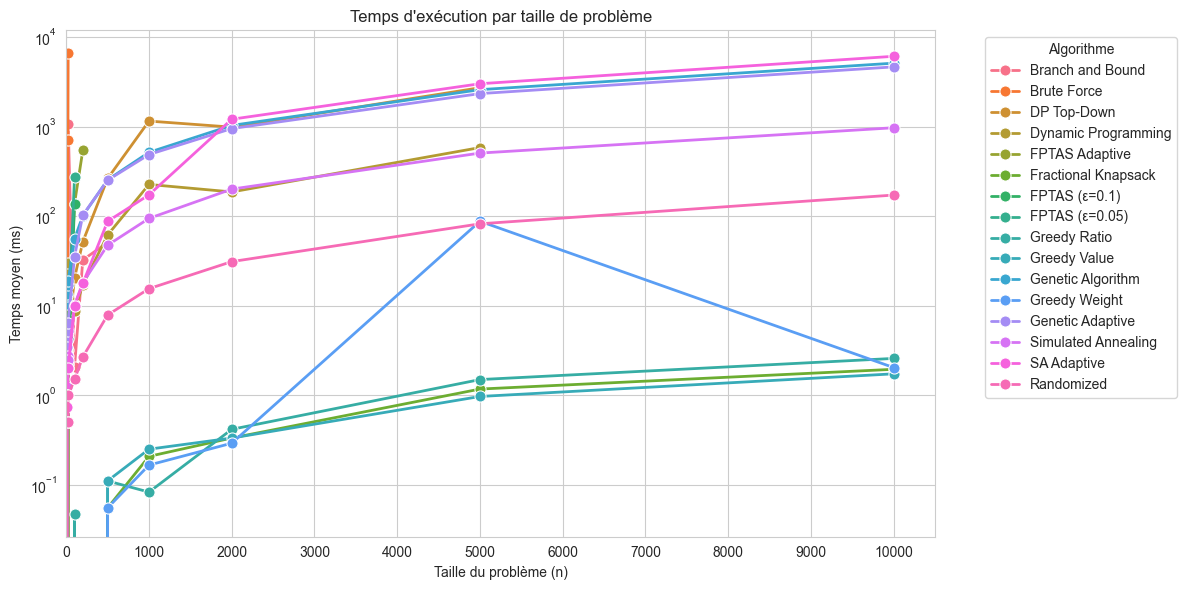

In [ ]:
# Chart 2: Execution time by size n
if results_df is not None:
    df = results_df.copy()
    
    # Average time by algorithm and size n
    agg_time = df.groupby(['algorithm', 'n'])['time_ms'].mean().reset_index()
    
    # Sort by n
    agg_time = agg_time.sort_values('n')
    
    plt.figure(figsize=(12,6))
    
    # Use lineplot with algorithm as hue (color)
    sns.lineplot(data=agg_time, x='n', y='time_ms', hue='algorithm', marker='o', palette='husl', linewidth=2, markersize=8)
    
    plt.xlabel('Problem size (n)')
    plt.ylabel('Average time (ms)')
    plt.title('Execution time by problem size')
    plt.yscale('log')
    
    # X axis with ticks every 1000
    max_n = int(agg_time['n'].max())
    plt.xticks(range(0, max_n + 1000, 1000))
    plt.xlim(0, max_n + 500)
    
    plt.legend(title='Algorithm', bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("results_df not loaded. Run first the cell that loads 'benchmark_results.csv'.")

Nombre de fichiers testés par algorithme et taille n:
n                    4      5      7      10     20     23     100    200    500    1000   2000   5000   10000
algorithm                                                                                                     
Branch and Bound         2      1      1      2      2      1     21      9     18      0      0      0      0
Brute Force              2      1      1      2      2      1      0      0      0      0      0      0      0
DP Top-Down              2      1      1      2      2      1     21      9     18     12      9      6      0
Dynamic Programming      2      1      1      2      2      1     21      9     18     12      9      6      0
FPTAS (ε=0.05)           2      1      1      2      2      1     21      0      0      0      0      0      0
FPTAS (ε=0.1)            2      1      1      2      2      1     21      0      0      0      0      0      0
FPTAS Adaptive           2      1      1      2      2    

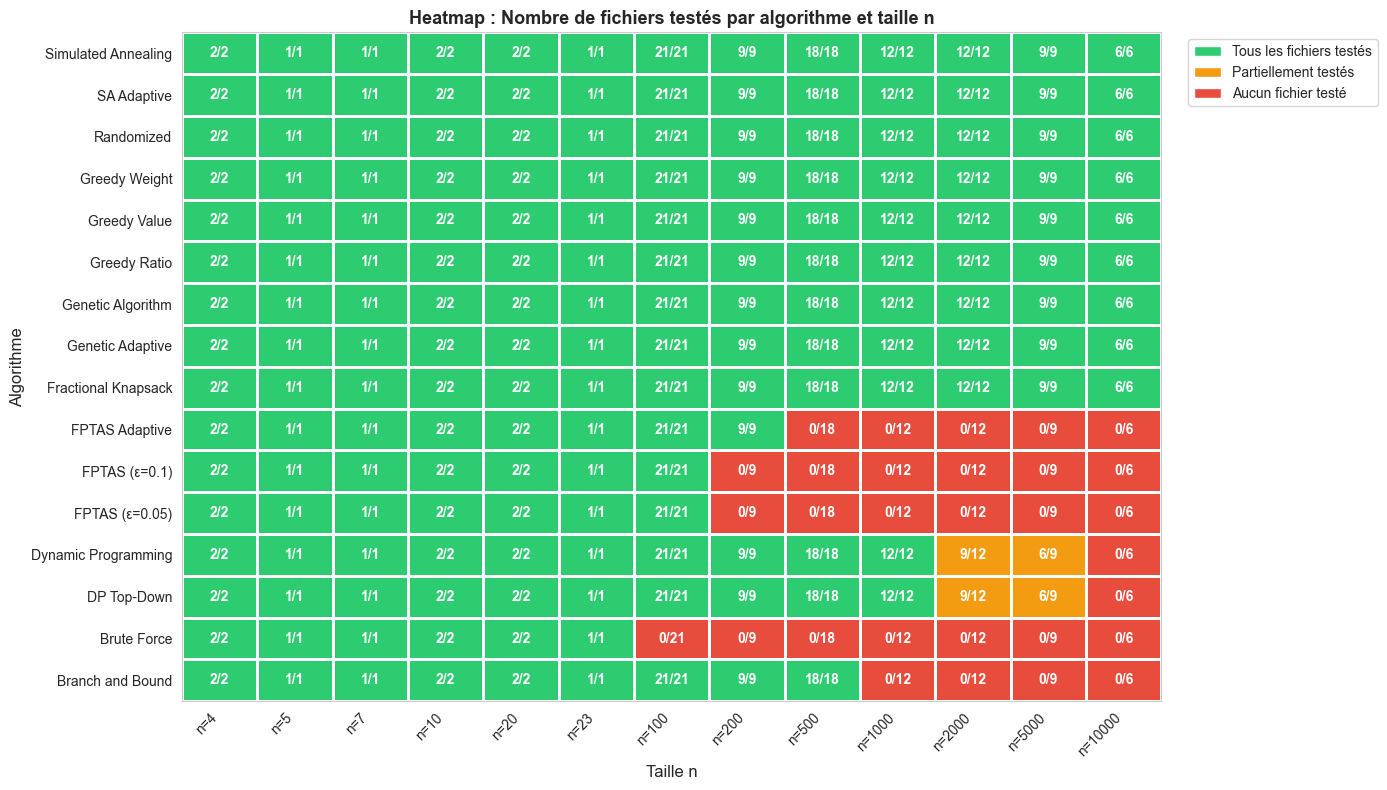

In [ ]:
# Chart 2b: Number of files tested by algorithm and size n
if results_df is not None:
    df = results_df.copy()
    
    # Count number of files tested by algorithm and size n
    # Each DataFrame row represents a test (a file tested by an algorithm)
    file_counts = df.groupby(['algorithm', 'n']).size().reset_index(name='nb_files')
    
    # Create pivot table for better visualization
    pivot_counts = file_counts.pivot(index='algorithm', columns='n', values='nb_files').fillna(0).astype(int)
    
    # Display table
    print("Number of files tested by algorithm and size n:")
    print(pivot_counts.to_string())
    print()
    
    # Reorder pivot columns in ascending order
    pivot_counts = pivot_counts[sorted(pivot_counts.columns)]
    
    # Calculate total files available for each n
    # (the max among all algorithms for each n)
    total_files_per_n = pivot_counts.max(axis=0)
    
    # Create matrix with 3 values: 0 = no files, 1 = partial, 2 = complete
    status_matrix = np.zeros_like(pivot_counts.values, dtype=float)
    for i in range(len(pivot_counts.index)):
        for j in range(len(pivot_counts.columns)):
            n_col = pivot_counts.columns[j]
            val = pivot_counts.values[i, j]
            total = total_files_per_n[n_col]
            if val >= total and total > 0:
                status_matrix[i, j] = 2  # Green (all files)
            elif val > 0:
                status_matrix[i, j] = 1  # Yellow (partial)
            else:
                status_matrix[i, j] = 0  # Red (no files)
    
    # Heatmap chart with 3 colors
    from matplotlib.colors import ListedColormap
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Custom colormap: red (0), yellow (1), green (2)
    cmap_3colors = ListedColormap(['#e74c3c', '#f39c12', '#2ecc71'])  # Red, Yellow, Green
    
    # Use pcolormesh with 3-color colormap
    im = ax.pcolormesh(status_matrix, cmap=cmap_3colors, edgecolors='white', linewidth=2, vmin=0, vmax=2)
    
    # Axes - center ticks in middle of cells
    ax.set_xticks(np.arange(len(pivot_counts.columns)) + 0.5)
    ax.set_yticks(np.arange(len(pivot_counts.index)) + 0.5)
    ax.set_xticklabels([f'n={n}' for n in pivot_counts.columns], fontsize=10)
    ax.set_yticklabels(pivot_counts.index, fontsize=10)
    
    # Rotate x labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Add values in each cell (centered in each box)
    for i in range(len(pivot_counts.index)):
        for j in range(len(pivot_counts.columns)):
            val = int(pivot_counts.values[i, j])
            n_col = pivot_counts.columns[j]
            total = int(total_files_per_n[n_col])
            # White text for better readability on colors
            ax.text(j + 0.5, i + 0.5, f'{val}/{total}', ha='center', va='center', 
                   color='white', fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Size n', fontsize=12)
    ax.set_ylabel('Algorithm', fontsize=12)
    ax.set_title('Heatmap: Number of files tested by algorithm and size n', fontsize=13, fontweight='bold')
    
    # Custom legend instead of colorbar
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#2ecc71', edgecolor='white', label='All files tested'),
        Patch(facecolor='#f39c12', edgecolor='white', label='Partially tested'),
        Patch(facecolor='#e74c3c', edgecolor='white', label='No files tested')
    ]
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=10)
    
    plt.tight_layout()
    plt.show()
else:
    print("results_df not loaded.")

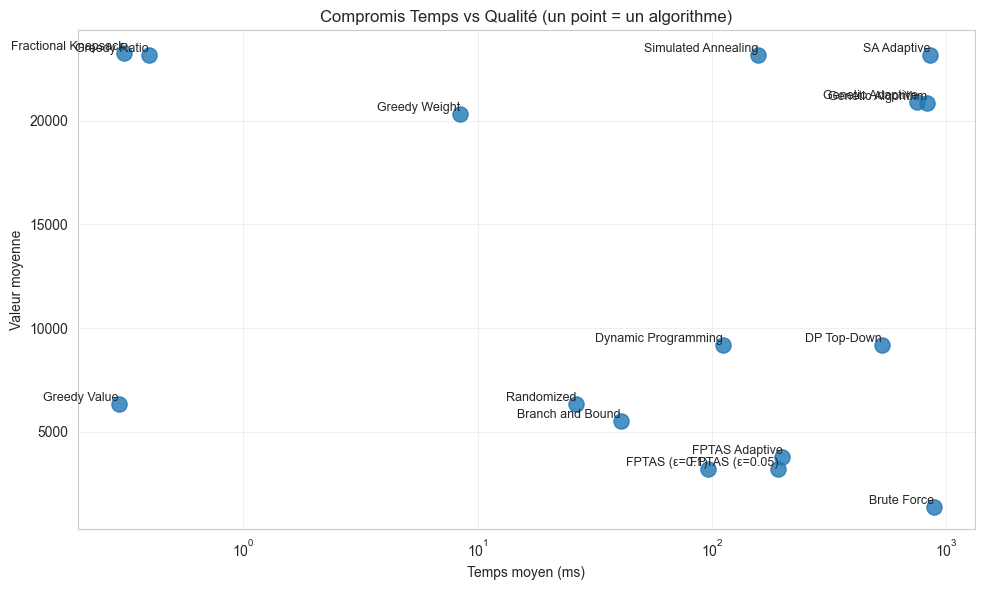

In [ ]:
# Chart 3: Scatter Time (X) vs Value (Y), 1 point = 1 algorithm (averages), annotated
if results_df is not None:
    df = results_df.copy()
    # take average time and value by algorithm
    summary = df.groupby('algorithm').agg({'time_ms':'mean','value':'mean'}).reset_index()
    
    plt.figure(figsize=(10,6))
    plt.scatter(summary['time_ms'], summary['value'], s=120, alpha=0.8)
    for i, row in summary.iterrows():
        plt.text(row['time_ms'], row['value'], row['algorithm'], fontsize=9,
                 verticalalignment='bottom', horizontalalignment='right')
    plt.xscale('log')
    plt.xlabel('Average time (ms)')
    plt.ylabel('Average value')
    plt.title('Time vs Quality tradeoff (one point = one algorithm)')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("results_df not loaded. Run first the cell that loads 'benchmark_results.csv'.")

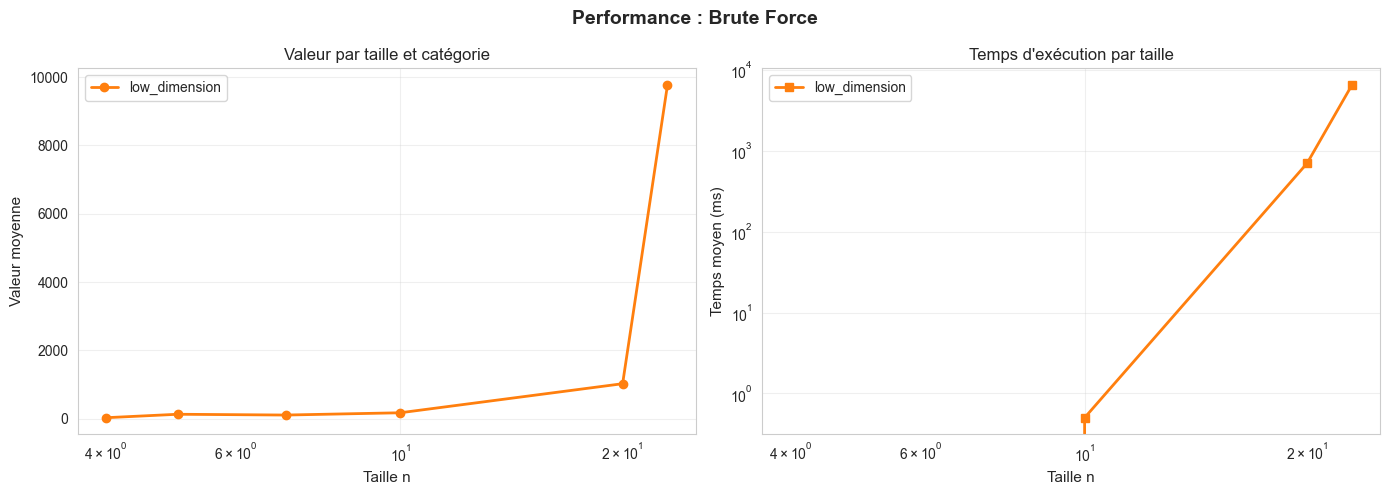

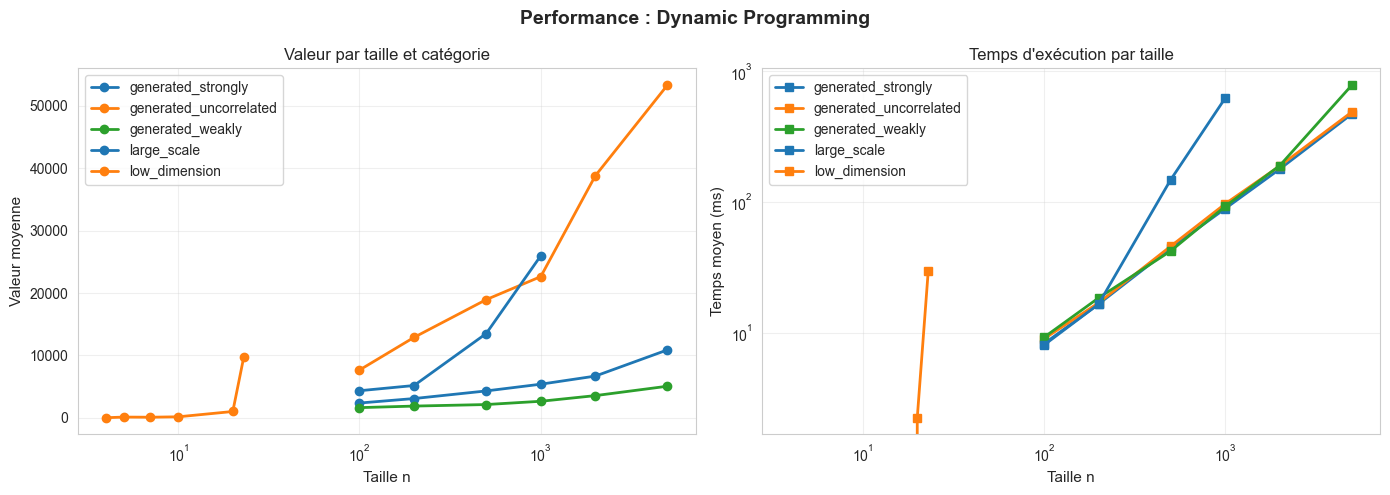

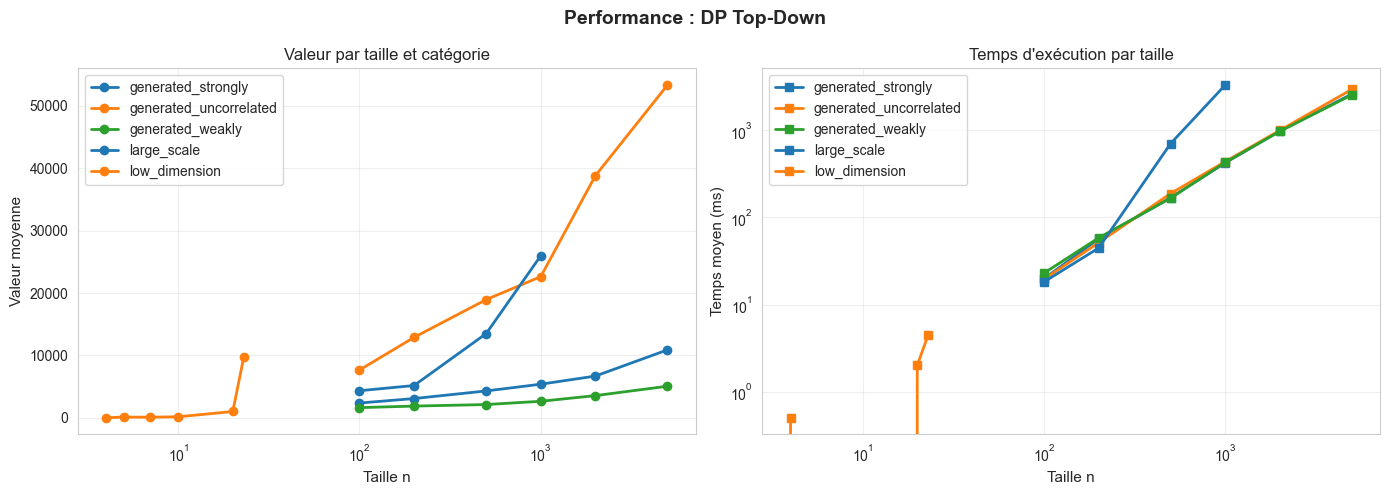

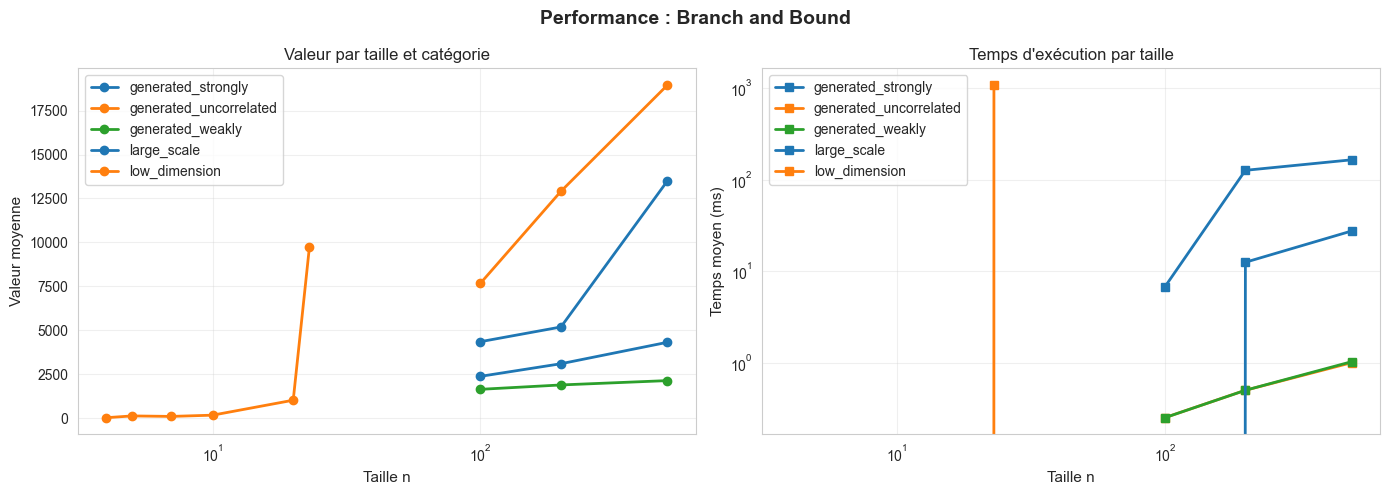

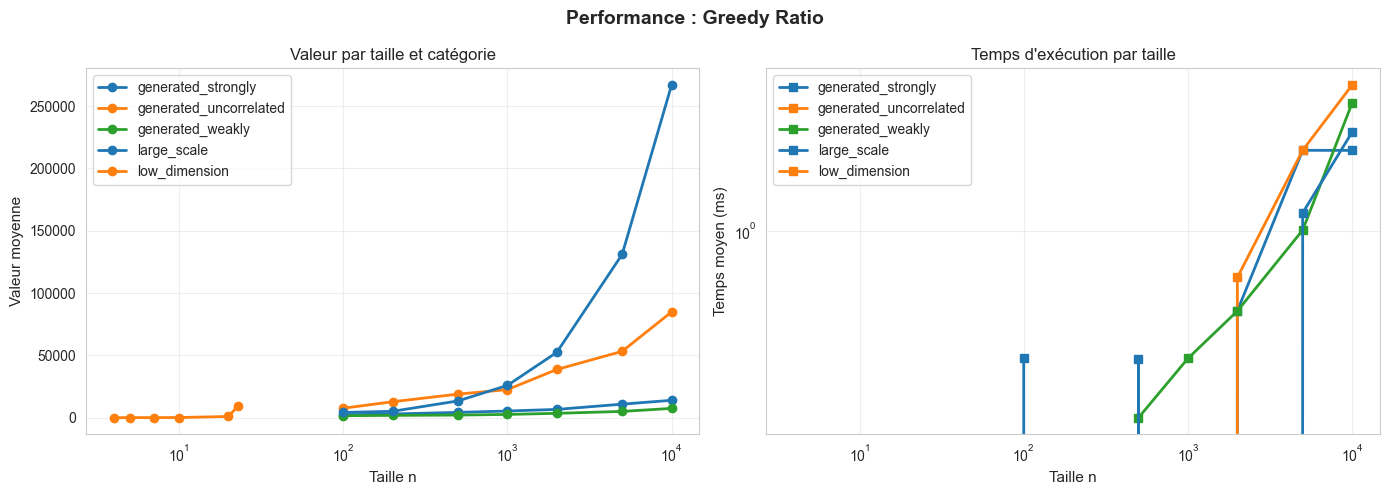

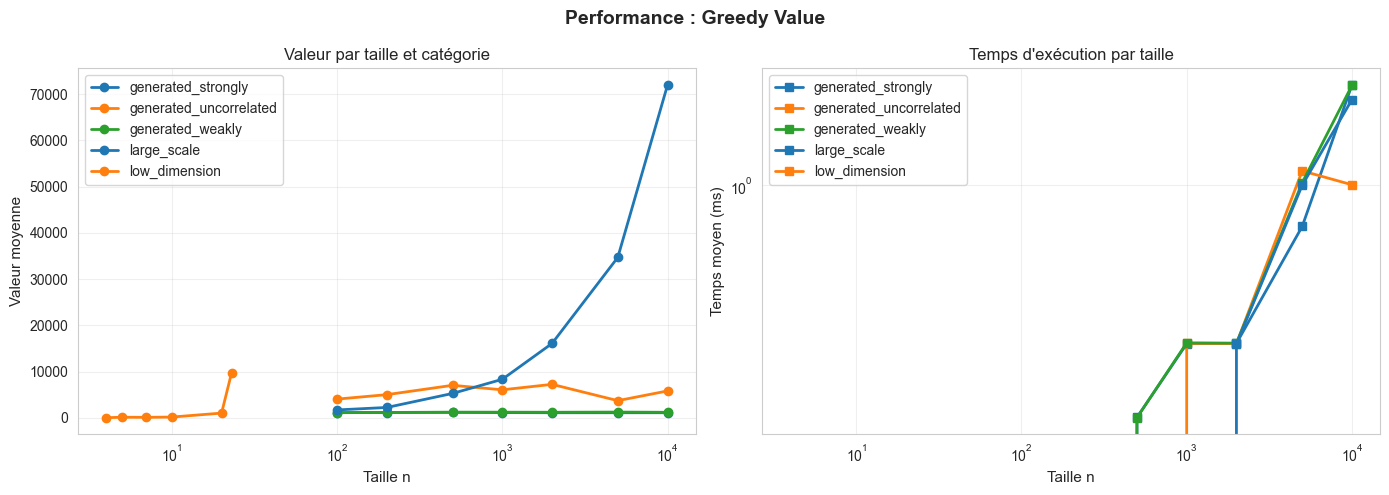

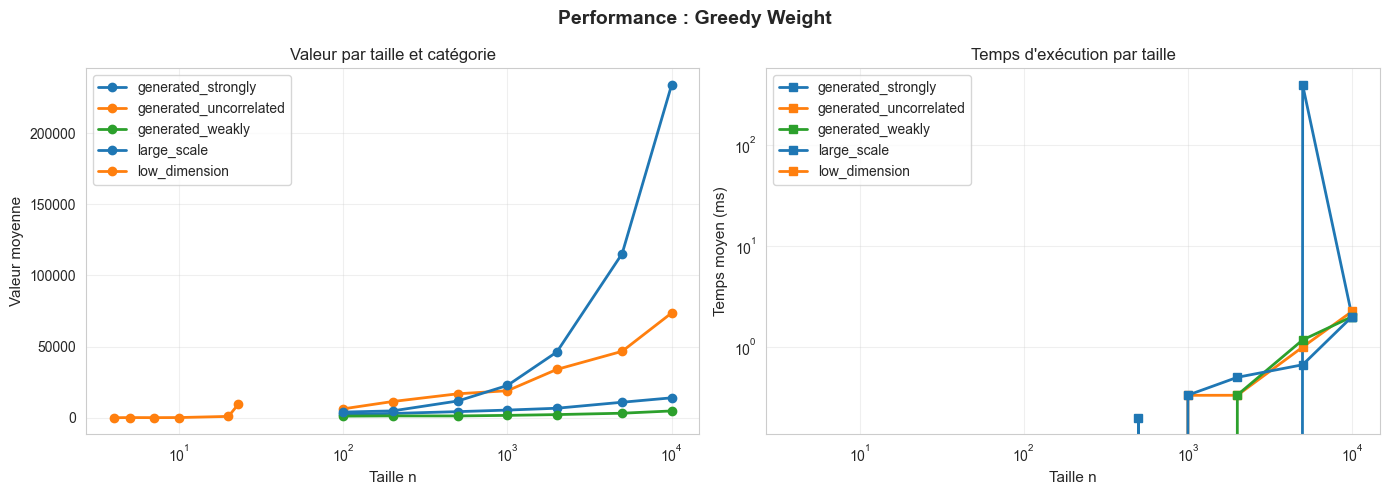

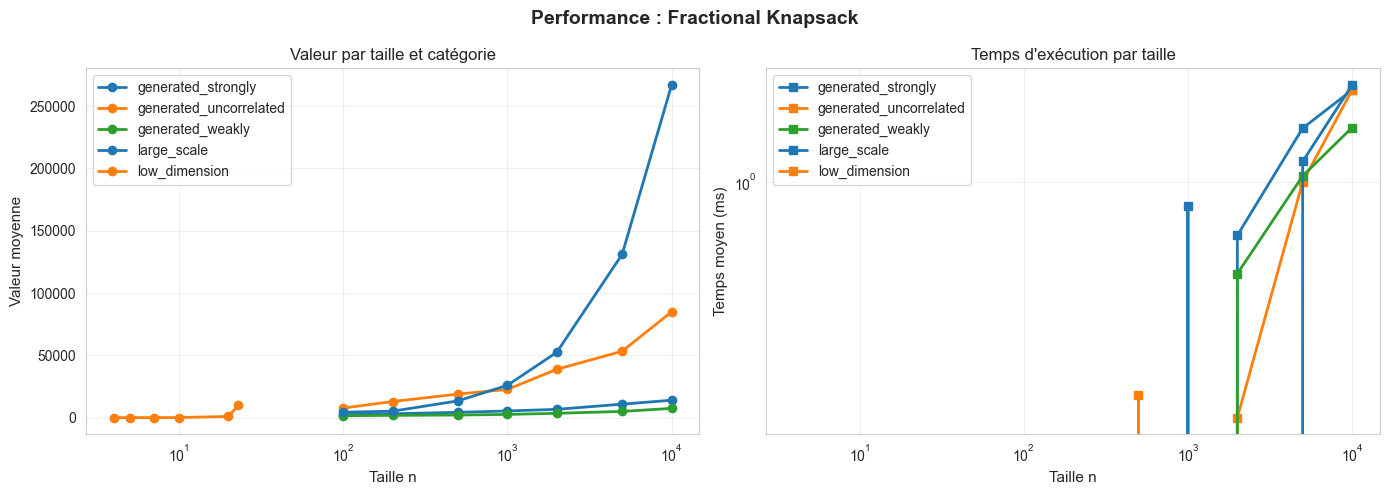

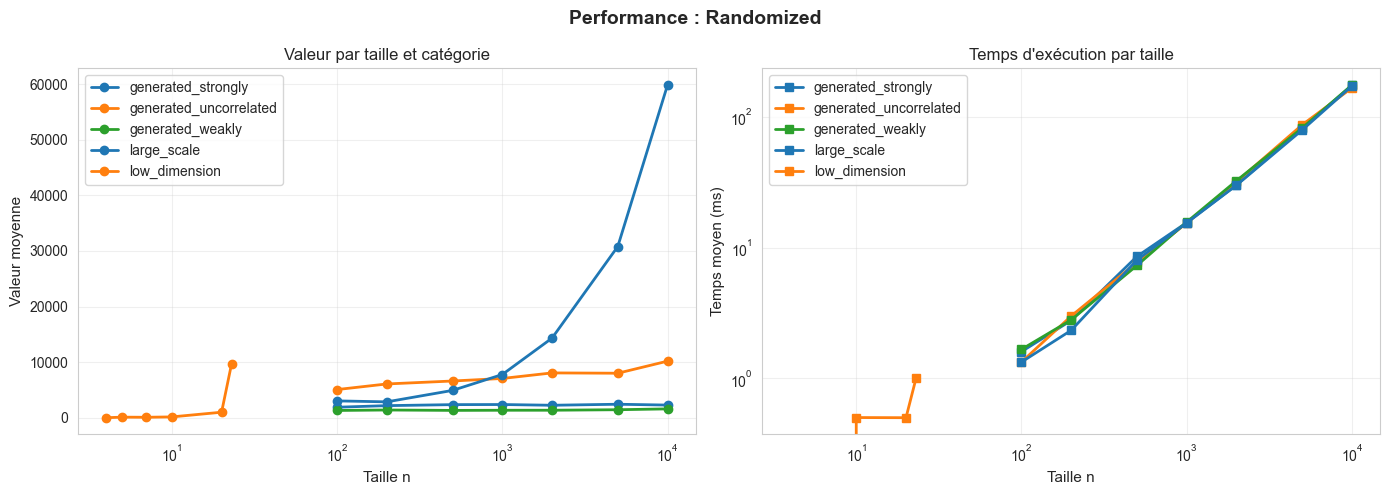

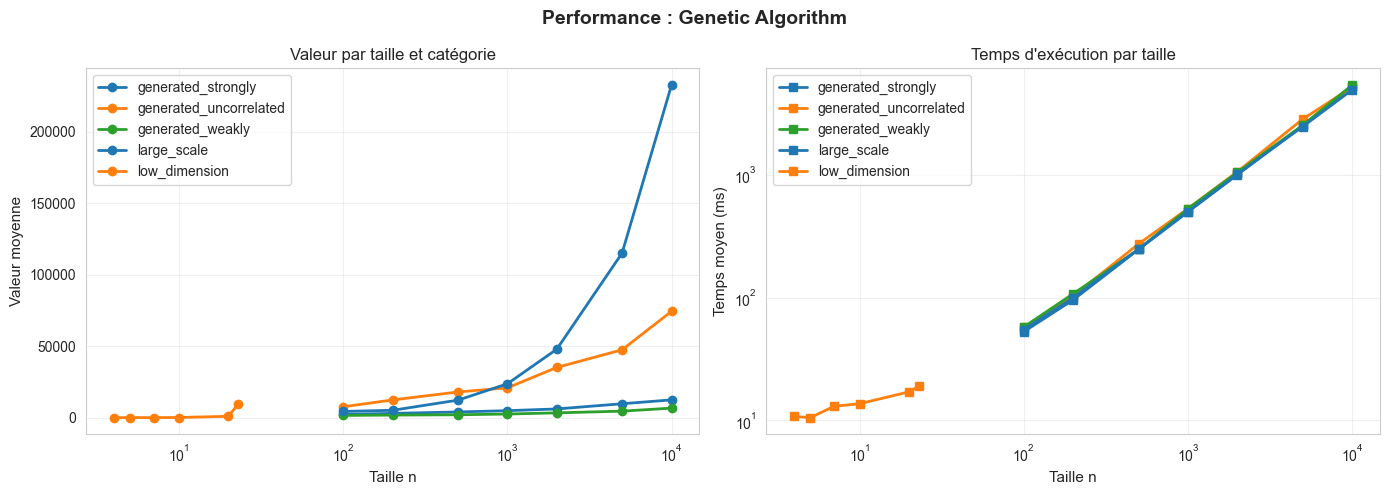

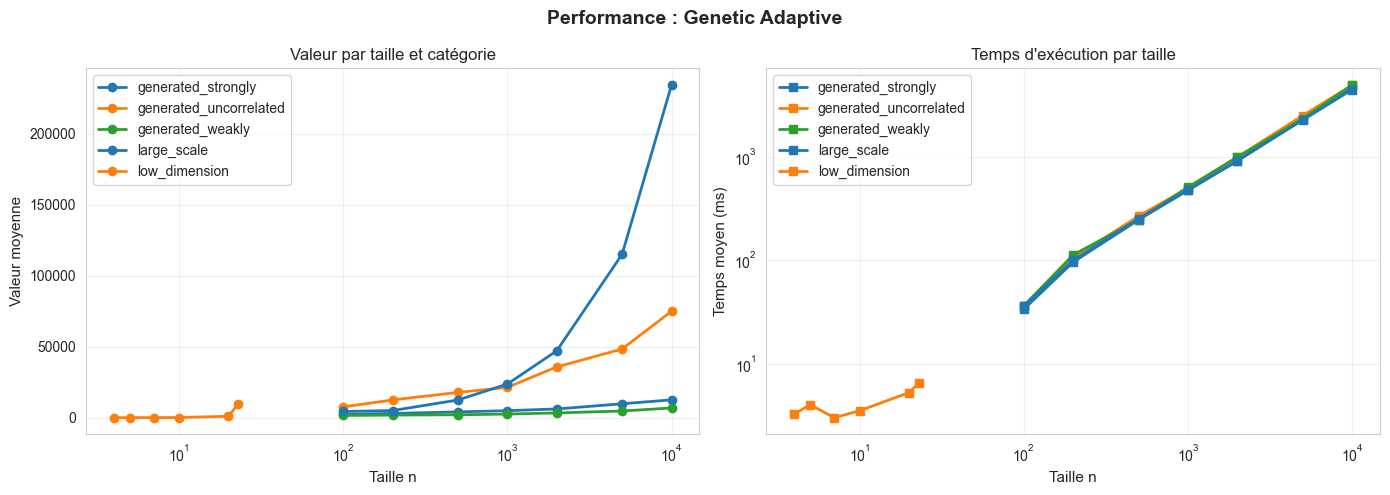

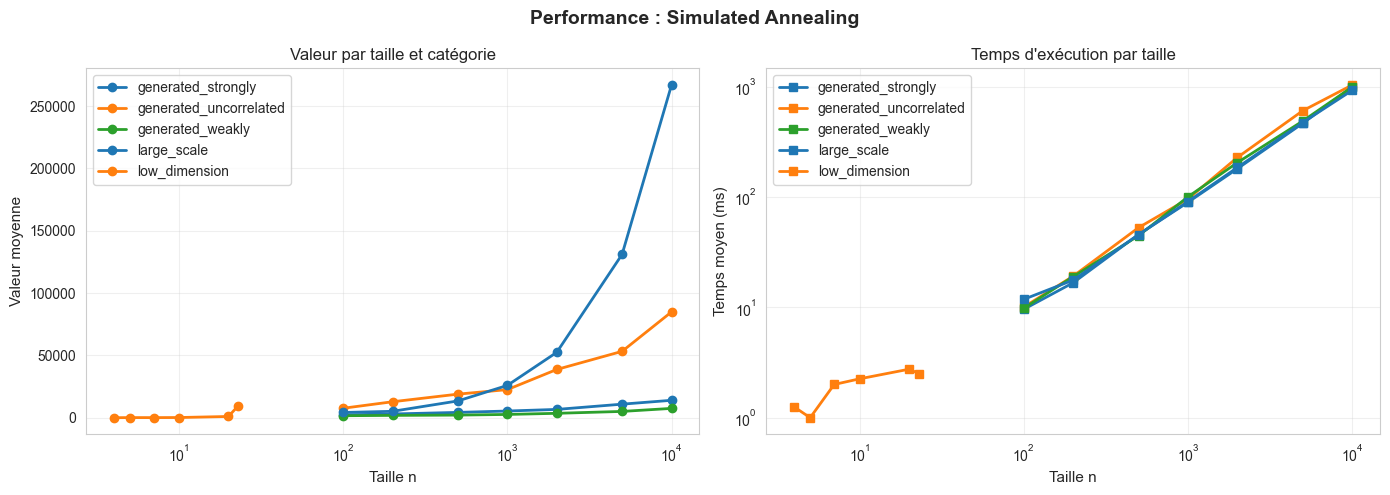

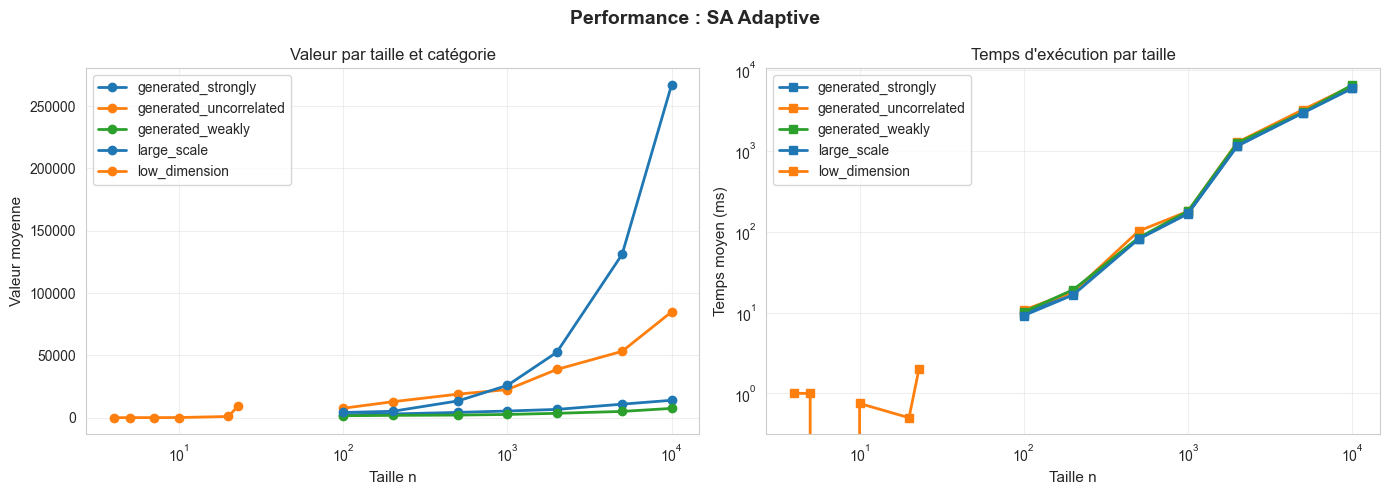

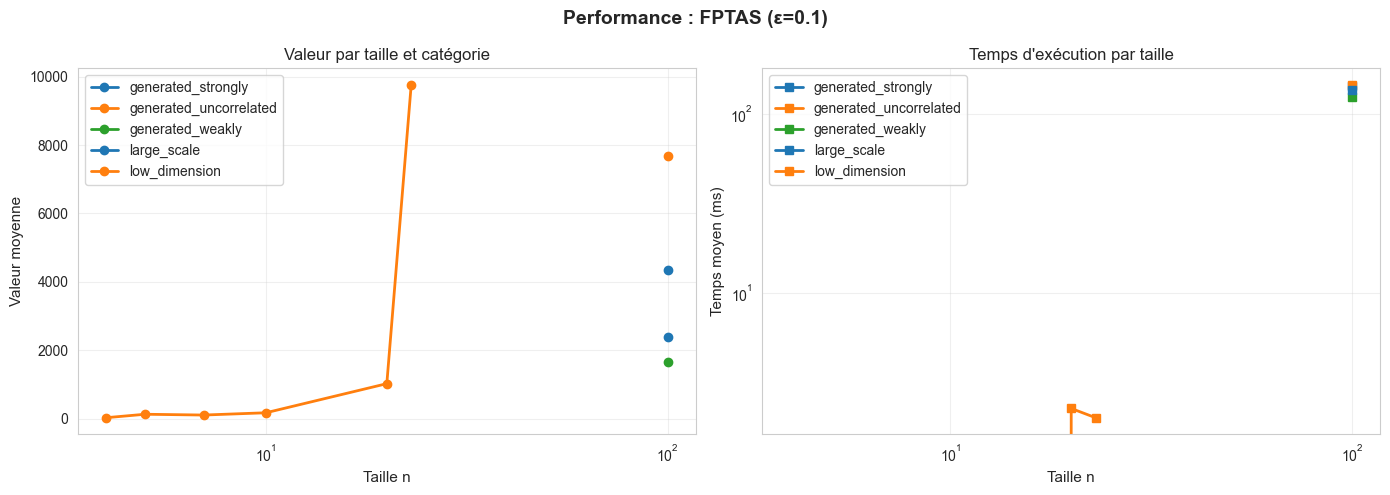

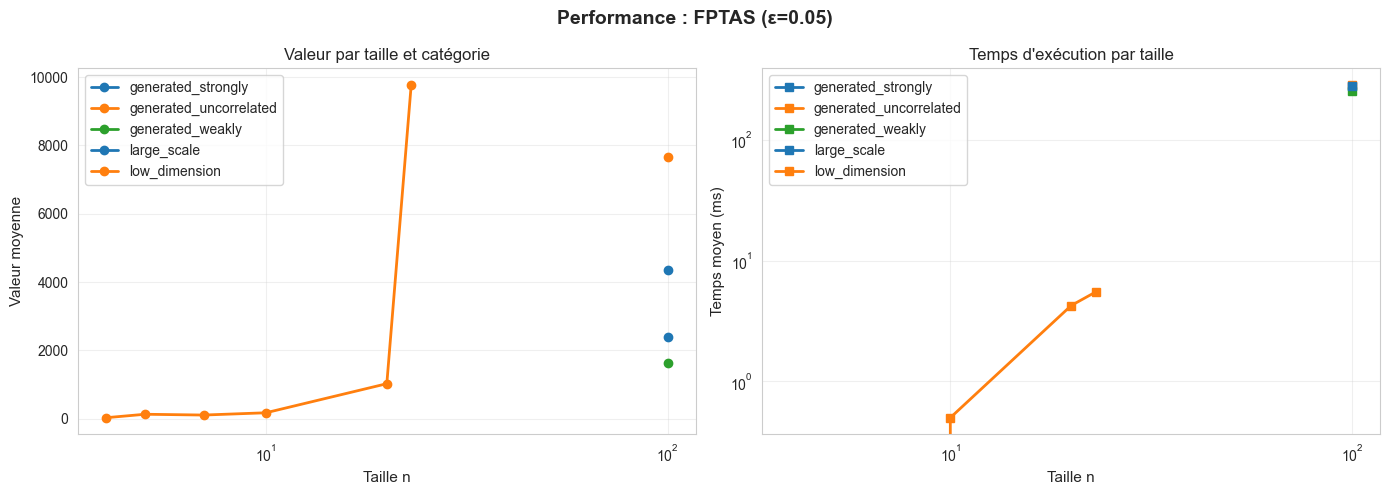

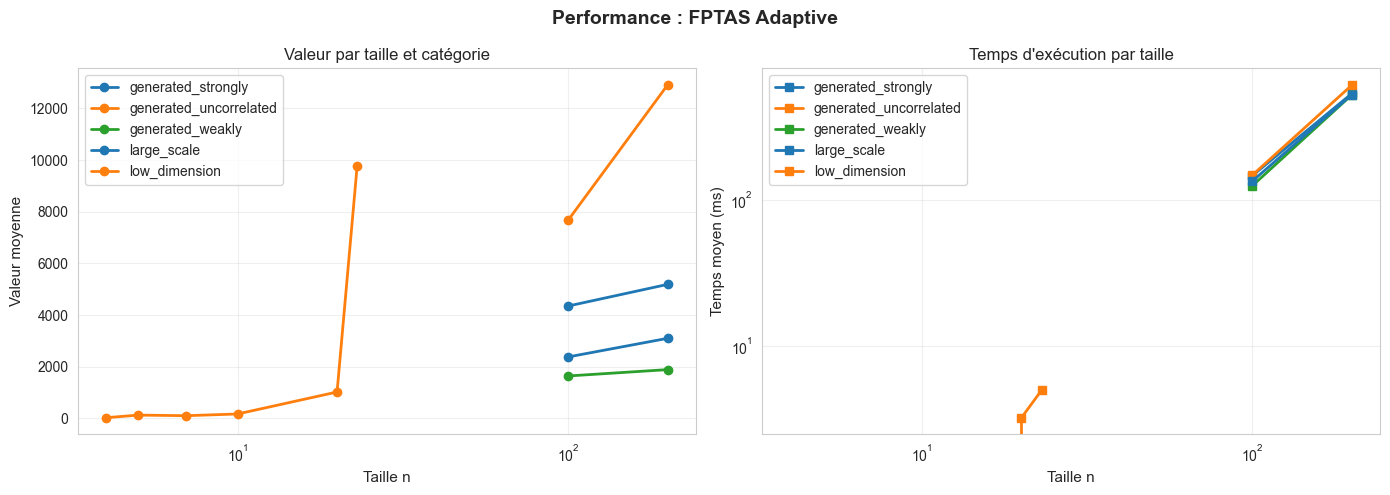

In [ ]:
if results_df is not None:
    df = results_df.copy()
    
    algorithms = df['algorithm'].unique()
    
    # colors for the two main categories
    colors_cat = {'large_scale':'#1f77b4','low_dimension':'#ff7f0e'}
    
    for algo in algorithms:
        algo_data = df[df['algorithm'] == algo].copy()
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        fig.suptitle(f'Performance: {algo}', fontsize=14, fontweight='bold')
        
        # Value by category and size n
        if 'category' in algo_data.columns:
            agg_value = algo_data.groupby(['category', 'n'])['value'].mean().reset_index()
            groups = agg_value['category'].unique()
        else:
            # fallback to 'correlation' if present
            agg_value = algo_data.groupby(['correlation', 'n'])['value'].mean().reset_index()
            agg_value = agg_value.rename(columns={'correlation':'category'})
            groups = agg_value['category'].unique()

        for cat in groups:
            cat_data = agg_value[agg_value['category'] == cat]
            axes[0].plot(cat_data['n'], cat_data['value'], marker='o', label=cat, linewidth=2,
                         color=colors_cat.get(cat, None))
        
        axes[0].set_xlabel('Size n', fontsize=11)
        axes[0].set_ylabel('Average value', fontsize=11)
        axes[0].set_title('Value by size and category')
        axes[0].legend()
        axes[0].grid(alpha=0.3)
        axes[0].set_xscale('log')
        
        # Execution time by size n
        if 'category' in algo_data.columns:
            agg_time = algo_data.groupby(['category', 'n'])['time_ms'].mean().reset_index()
        else:
            agg_time = algo_data.groupby(['correlation', 'n'])['time_ms'].mean().reset_index()
            agg_time = agg_time.rename(columns={'correlation':'category'})

        for cat in agg_time['category'].unique():
            cat_data = agg_time[agg_time['category'] == cat]
            axes[1].plot(cat_data['n'], cat_data['time_ms'], marker='s', label=cat, linewidth=2,
                         color=colors_cat.get(cat, None))
        
        axes[1].set_xlabel('Size n', fontsize=11)
        axes[1].set_ylabel('Average time (ms)', fontsize=11)
        axes[1].set_title('Execution time by size')
        axes[1].legend()
        axes[1].grid(alpha=0.3)
        axes[1].set_xscale('log')
        axes[1].set_yscale('log')
        
        plt.tight_layout()
        plt.show()
        print(f"\n{'='*60}\n")
else:
    print("results_df not loaded. Run first the cell that loads 'benchmark_results.csv'.")

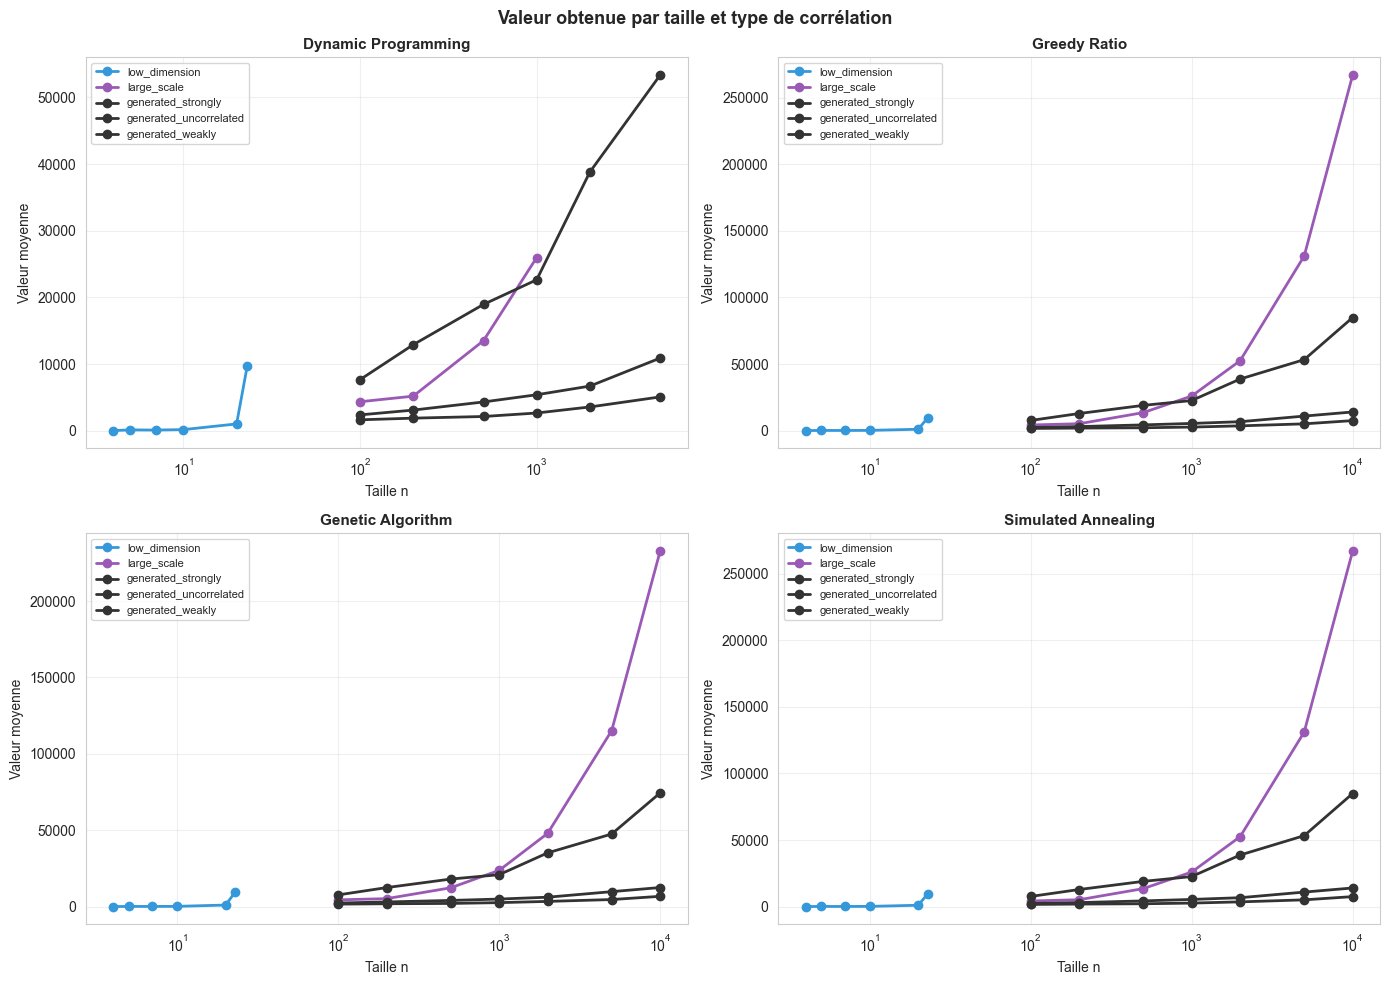

In [ ]:
# Chart 5: Performance evolution by n for each correlation type
if results_df is not None:
    df = results_df.copy()
    
    # Color palette for correlations
    corr_colors = {
        'uncorrelated': '#2ecc71',
        'weakly_correlated': '#f39c12', 
        'strongly_correlated': '#e74c3c',
        'low_dimension': '#3498db',
        'large_scale': '#9b59b6'
    }
    
    # Select a few representative algorithms for readability
    algos_to_show = ['Dynamic Programming', 'Greedy Ratio', 'Genetic Algorithm', 'Simulated Annealing']
    algos_present = [a for a in algos_to_show if a in df['algorithm'].unique()]
    
    if len(algos_present) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.flatten()
        
        for idx, algo in enumerate(algos_present[:4]):
            ax = axes[idx]
            algo_data = df[df['algorithm'] == algo]
            
            for corr in algo_data['correlation'].unique():
                corr_data = algo_data[algo_data['correlation'] == corr]
                agg = corr_data.groupby('n').agg({'value': 'mean', 'time_ms': 'mean'}).reset_index()
                agg = agg.sort_values('n')
                
                color = corr_colors.get(corr, '#333')
                ax.plot(agg['n'], agg['value'], 'o-', label=corr, color=color, linewidth=2, markersize=6)
            
            ax.set_xlabel('Size n', fontsize=10)
            ax.set_ylabel('Average value', fontsize=10)
            ax.set_title(f'{algo}', fontsize=11, fontweight='bold')
            ax.legend(fontsize=8)
            ax.grid(alpha=0.3)
            ax.set_xscale('log')
        
        plt.suptitle('Value obtained by size and correlation type', fontsize=13, fontweight='bold')
        plt.tight_layout()
        plt.show()
else:
    print("results_df not loaded.")

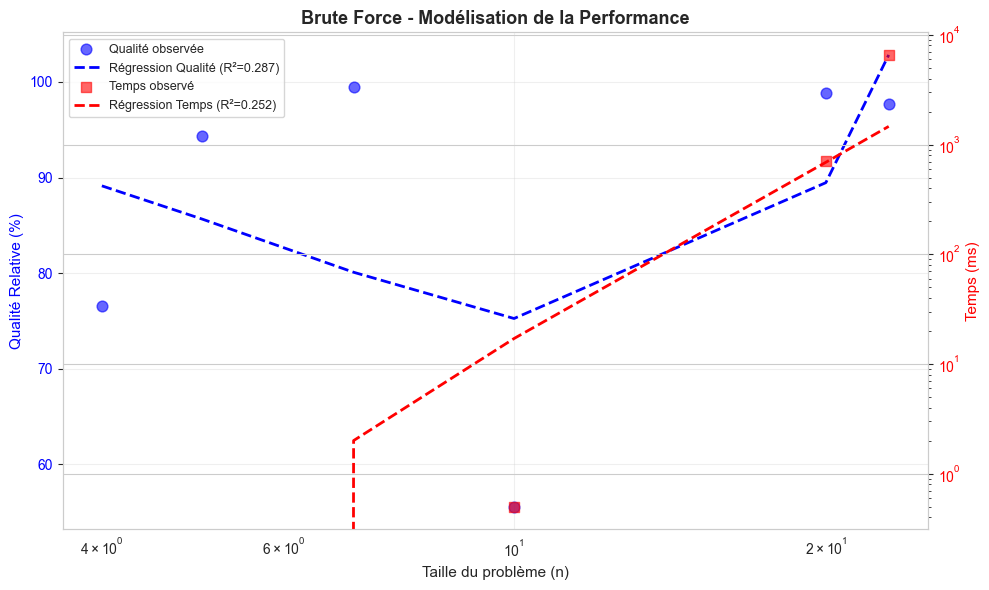

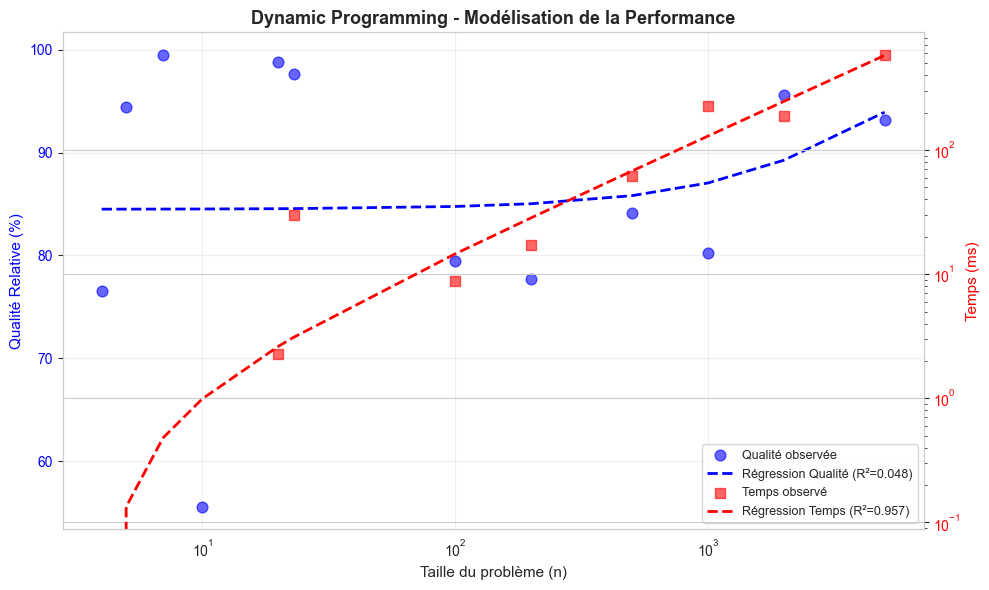

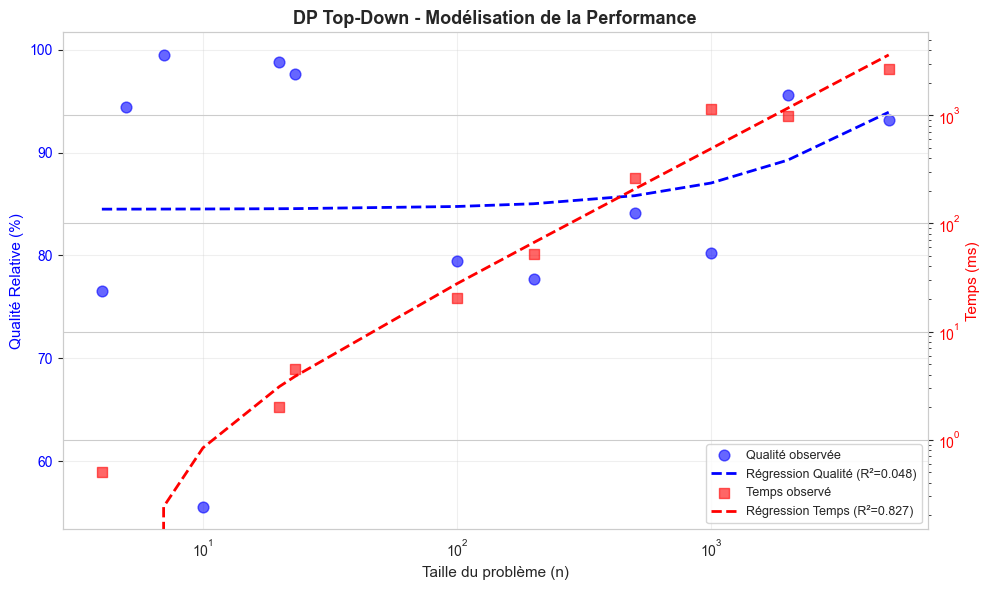

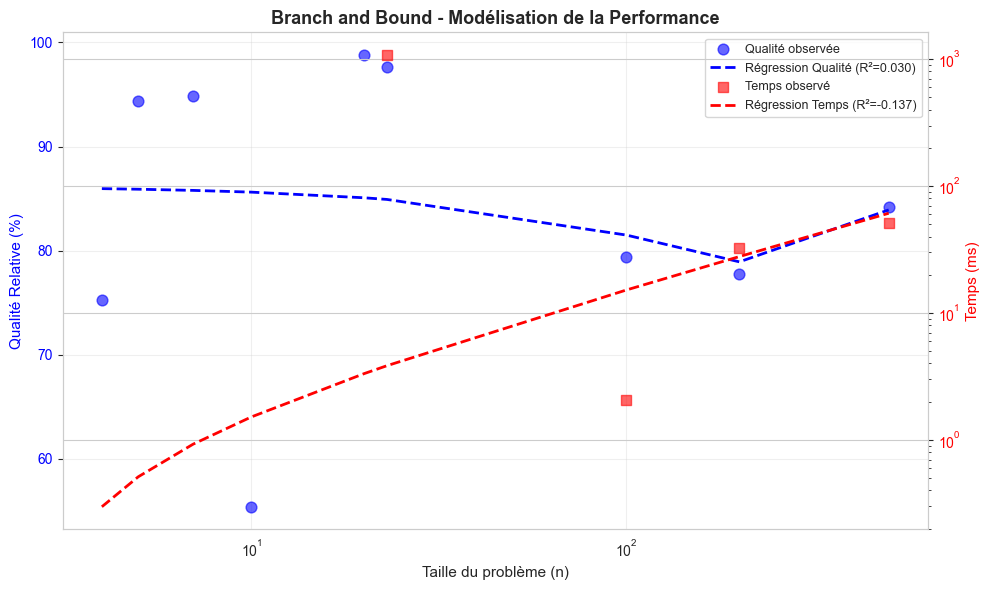

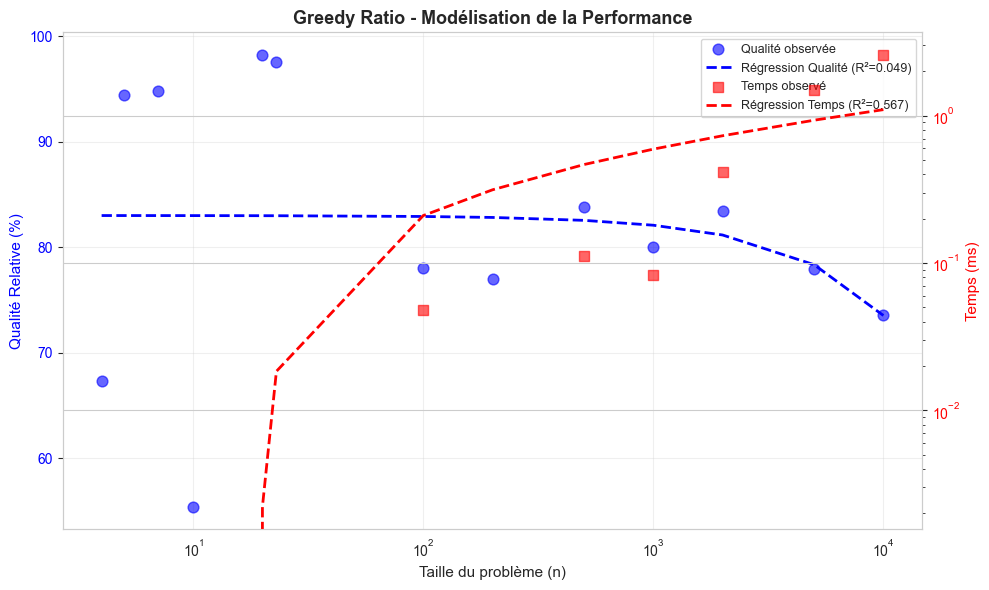

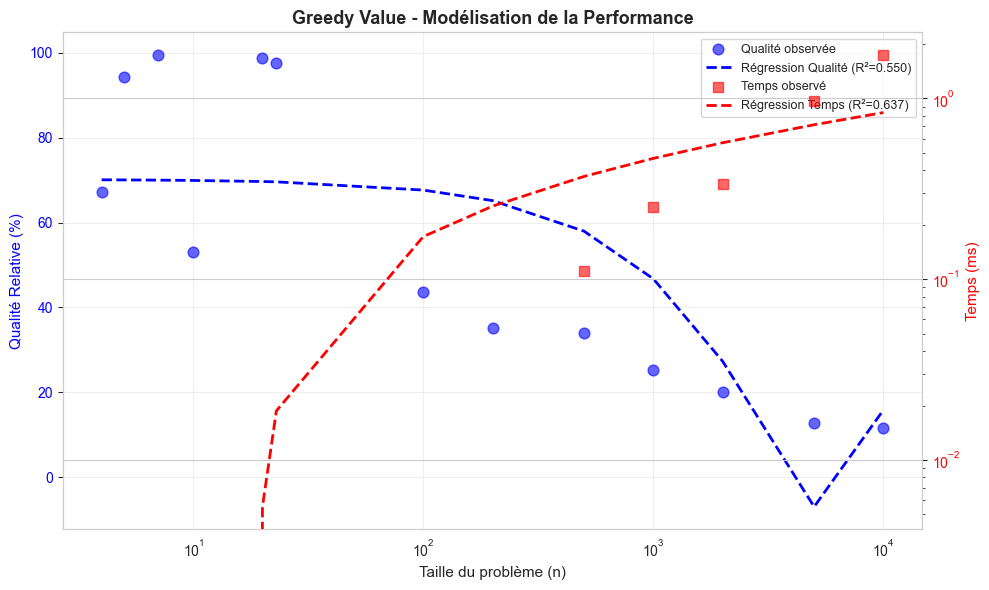

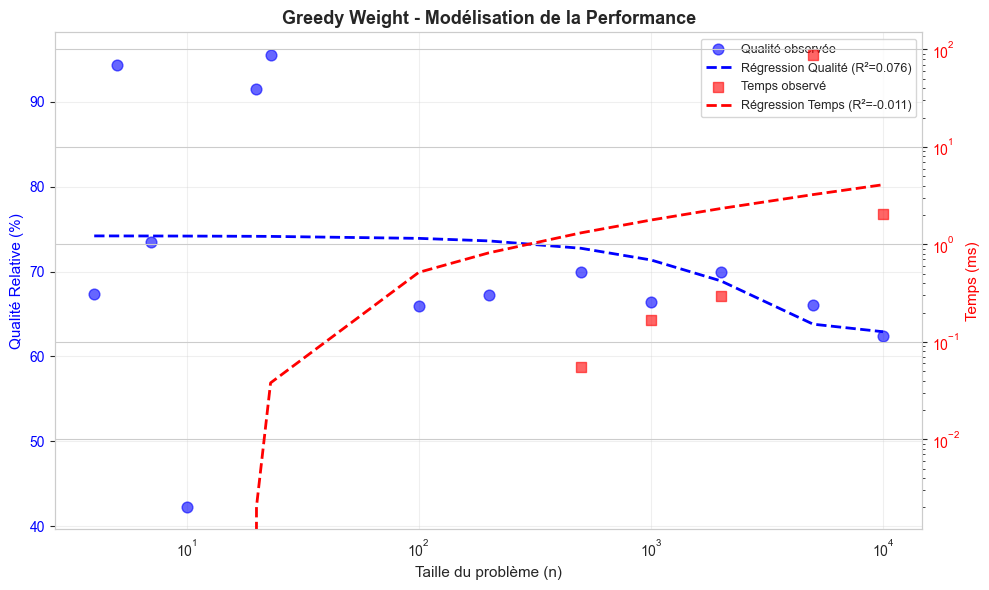

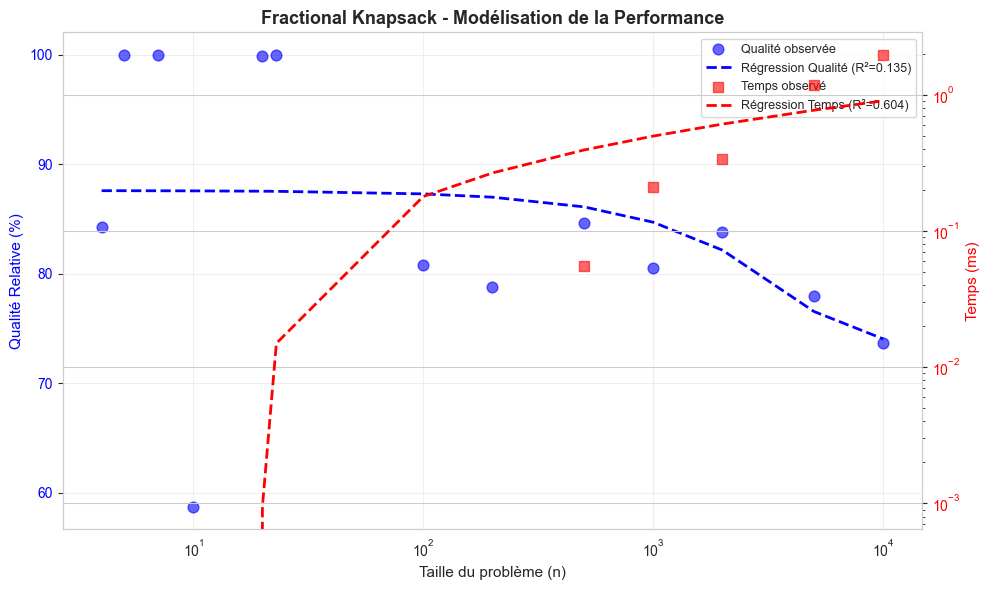

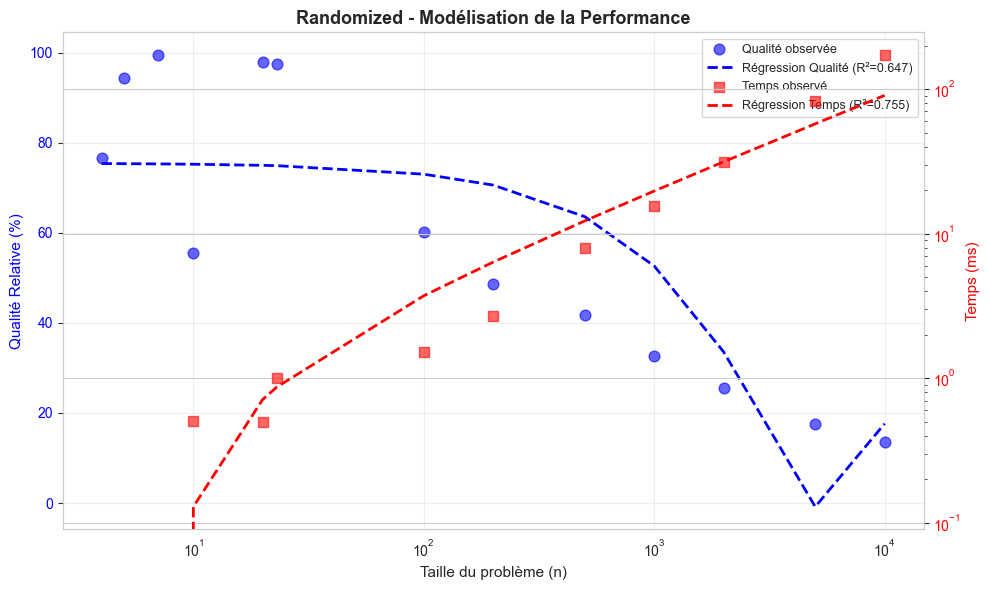

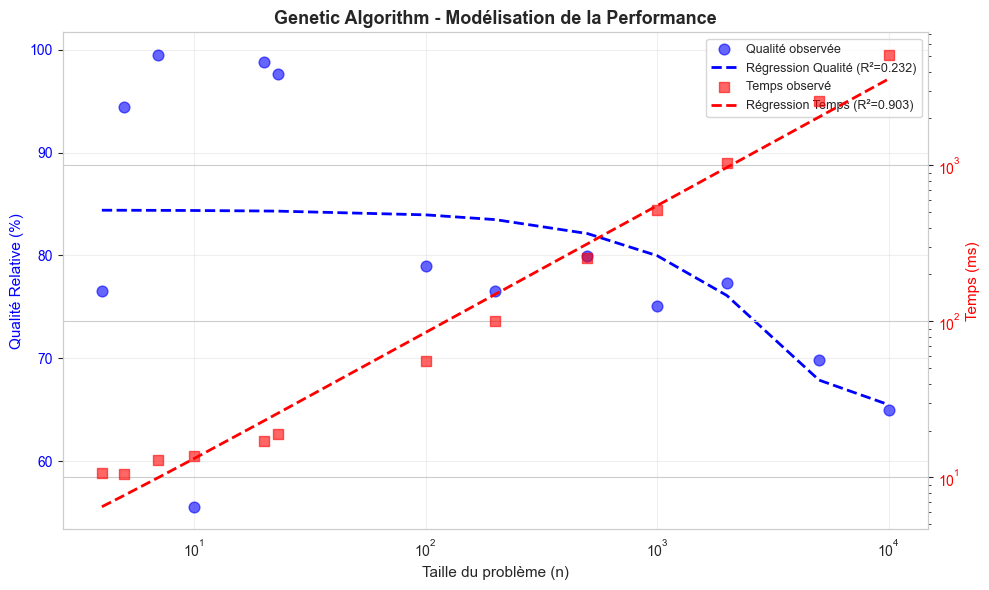

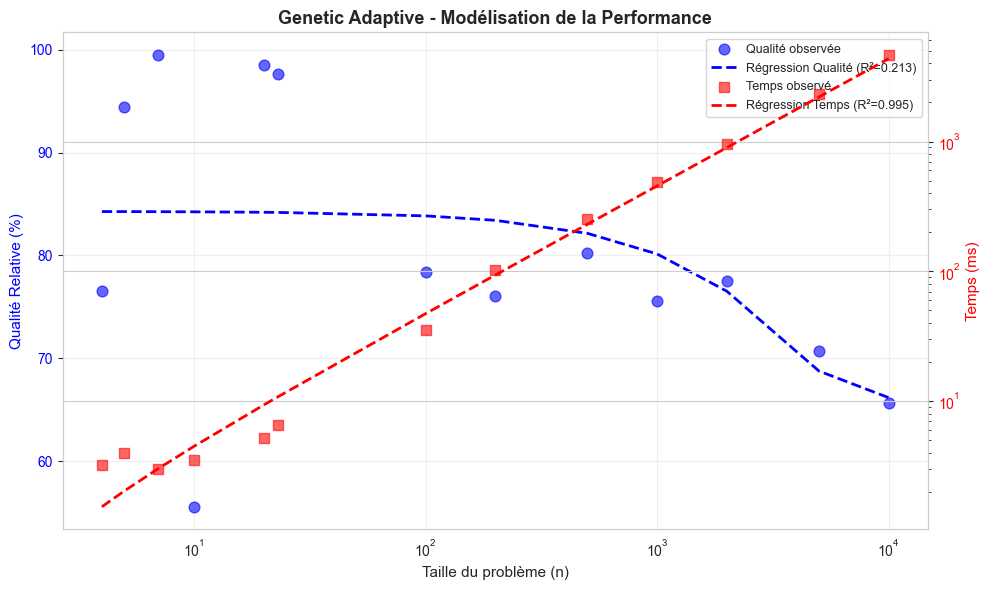

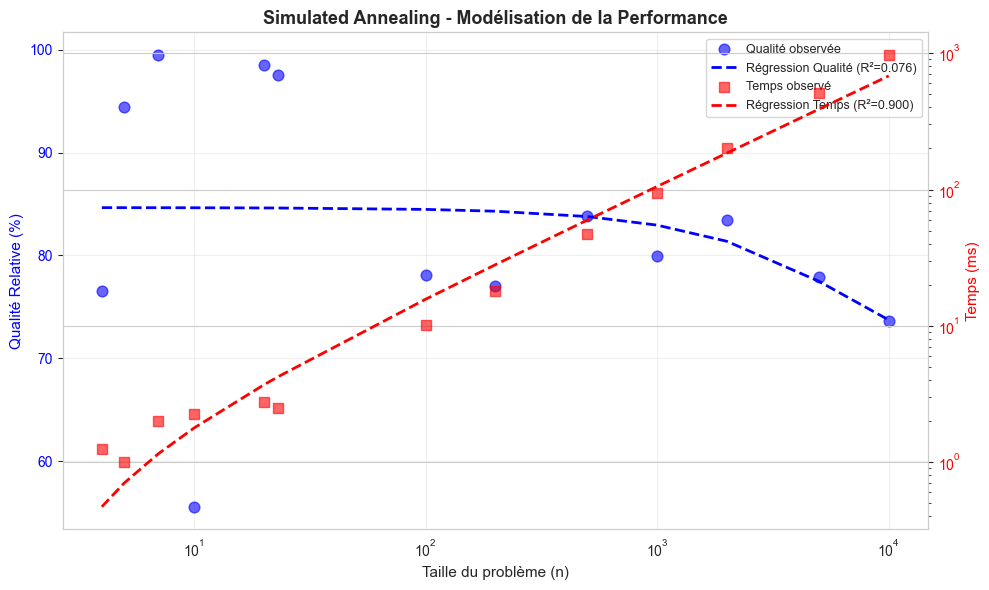

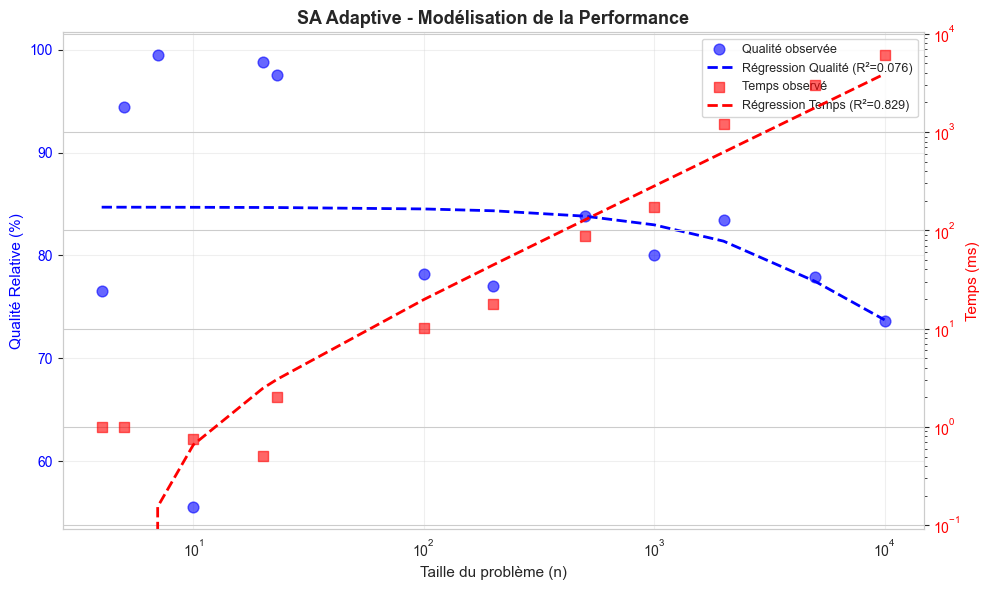

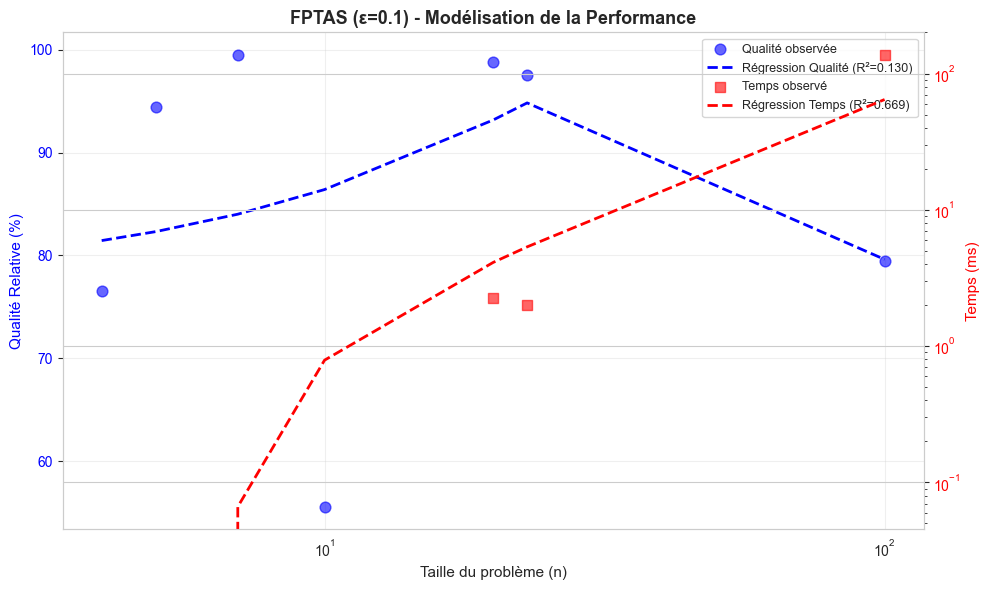

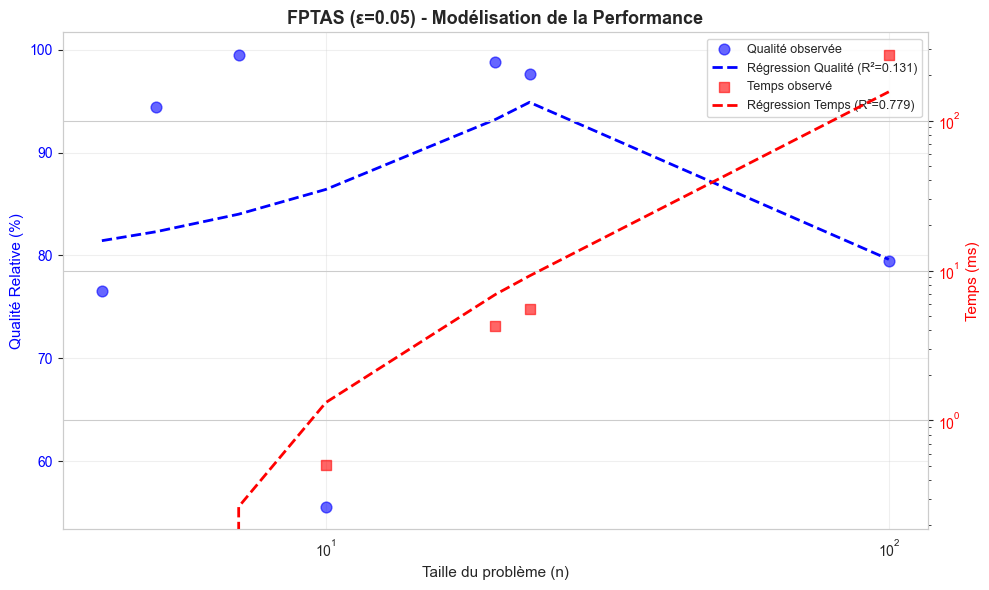

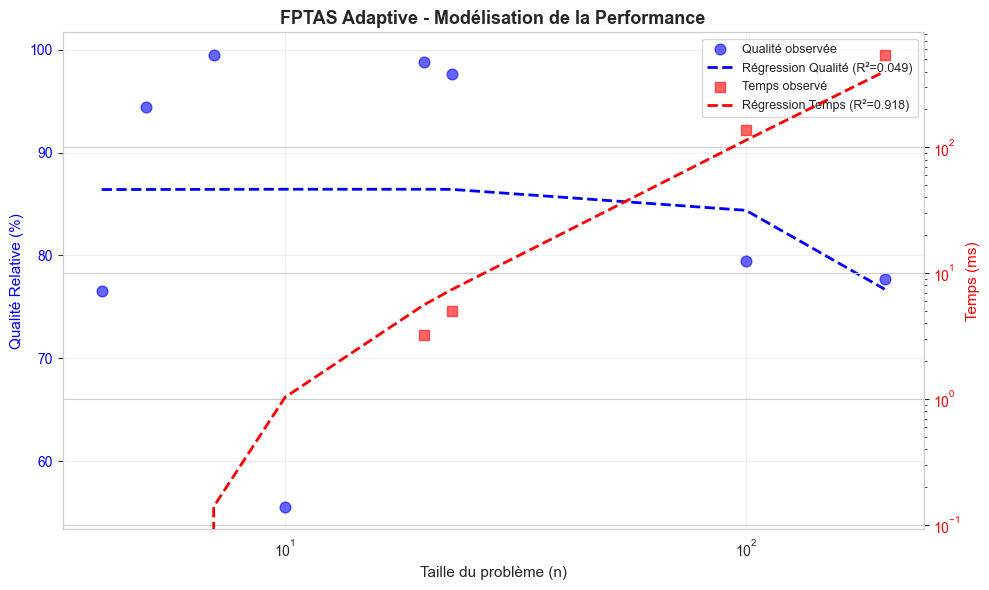


ANALYSE DE RÉGRESSION - MODÉLISATION DE LA PERFORMANCE

Brute Force:
  Qualité: R² = 0.287 (tendance: décroissant)
  Temps: R² = 0.252 (complexité estimée: O(n^5.63))

Dynamic Programming:
  Qualité: R² = 0.048 (tendance: croissant)
  Temps: R² = 0.957 (complexité estimée: O(n^0.93))

DP Top-Down:
  Qualité: R² = 0.048 (tendance: croissant)
  Temps: R² = 0.827 (complexité estimée: O(n^1.24))

Branch and Bound:
  Qualité: R² = 0.030 (tendance: décroissant)
  Temps: R² = -0.137 (complexité estimée: O(n^0.84))

Greedy Ratio:
  Qualité: R² = 0.049 (tendance: décroissant)
  Temps: R² = 0.567 (complexité estimée: O(n^0.12))

Greedy Value:
  Qualité: R² = 0.550 (tendance: décroissant)
  Temps: R² = 0.637 (complexité estimée: O(n^0.10))

Greedy Weight:
  Qualité: R² = 0.076 (tendance: décroissant)
  Temps: R² = -0.011 (complexité estimée: O(n^0.26))

Fractional Knapsack:
  Qualité: R² = 0.135 (tendance: décroissant)
  Temps: R² = 0.604 (complexité estimée: O(n^0.10))

Randomized:
  Qualité: R

In [ ]:
if results_df is not None:
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.metrics import r2_score
    import warnings
    warnings.filterwarnings('ignore')
    
    df = results_df.copy()
    
    # Normalize quality
    df['max_value_per_instance'] = df.groupby(['n', 'correlation'])['value'].transform('max')
    df['relative_quality'] = (df['value'] / df['max_value_per_instance']) * 100
    
    # Take all algorithms present in the data
    all_algos = df['algorithm'].unique().tolist()
    
    regression_results = []
    
    # A separate chart for each algorithm
    for algo in all_algos:
        algo_data = df[df['algorithm'] == algo].copy()
        
        if len(algo_data) == 0:
            continue
        
        # Group by size
        grouped = algo_data.groupby('n').agg({
            'relative_quality': 'mean',
            'time_ms': 'mean'
        }).reset_index().sort_values('n')
        
        if len(grouped) < 2:
            continue
        
        X = grouped['n'].values.reshape(-1, 1)
        y_quality = grouped['relative_quality'].values
        y_time = grouped['time_ms'].values
        
        # Polynomial regression for quality
        poly_features = PolynomialFeatures(degree=2)
        X_poly = poly_features.fit_transform(X)
        
        reg_quality = LinearRegression()
        reg_quality.fit(X_poly, y_quality)
        y_pred_quality = reg_quality.predict(X_poly)
        r2_quality = r2_score(y_quality, y_pred_quality)
        
        # Regression for time (log-log)
        X_log = np.log1p(X)
        y_log = np.log1p(y_time)
        reg_time = LinearRegression()
        reg_time.fit(X_log, y_log)
        y_pred_time = np.expm1(reg_time.predict(X_log))
        r2_time = r2_score(y_time, y_pred_time)
        
        # Create individual chart for this algorithm
        fig, ax = plt.subplots(figsize=(10, 6))
        ax2 = ax.twinx()
        
        # Quality
        ax.scatter(grouped['n'], grouped['relative_quality'], color='blue', 
                  alpha=0.6, s=60, label='Observed quality', zorder=3)
        ax.plot(grouped['n'], y_pred_quality, 'b--', linewidth=2, 
               label=f'Quality Regression (R²={r2_quality:.3f})', zorder=2)
        ax.set_xlabel('Problem size (n)', fontsize=11)
        ax.set_ylabel('Relative Quality (%)', fontsize=11, color='blue')
        ax.tick_params(axis='y', labelcolor='blue')
        ax.set_xscale('log')
        
        # Time
        ax2.scatter(grouped['n'], grouped['time_ms'], color='red', 
                   alpha=0.6, s=60, marker='s', label='Observed time', zorder=3)
        ax2.plot(grouped['n'], y_pred_time, 'r--', linewidth=2, 
                label=f'Time Regression (R²={r2_time:.3f})', zorder=2)
        ax2.set_ylabel('Time (ms)', fontsize=11, color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        ax2.set_yscale('log')
        
        ax.set_title(f'{algo} - Performance Modeling', 
                    fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Combined legend
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=9)
        
        plt.tight_layout()
        plt.show()
        
        # Store results
        quality_trend_coef = reg_quality.coef_[1] if len(reg_quality.coef_) > 1 else reg_quality.coef_[0]
        time_coef = float(reg_time.coef_[0])
        
        regression_results.append({
            'algorithm': algo,
            'quality_r2': r2_quality,
            'time_r2': r2_time,
            'quality_trend': 'decreasing' if quality_trend_coef < 0 else 'increasing',
            'time_complexity': f"O(n^{time_coef:.2f})" if time_coef > 0 else 'O(1)'
        })
    
    # Summary table
    print("\n" + "="*80)
    print("REGRESSION ANALYSIS - PERFORMANCE MODELING")
    print("="*80)
    
    reg_df = pd.DataFrame(regression_results)
    for _, row in reg_df.iterrows():
        print(f"\n{row['algorithm']}:")
        print(f"  Quality: R² = {row['quality_r2']:.3f} (trend: {row['quality_trend']})")
        print(f"  Time: R² = {row['time_r2']:.3f} (estimated complexity: {row['time_complexity']})")
    
    print("\n" + "="*80)
    print("INTERPRETATION:")
    print("="*80)
    print("R² close to 1 = model predicts data well")
    print("R² < 0.5 = unreliable model, variable performance")
    print("Estimated complexity gives an idea of algorithm scalability")
else:
    print("results_df not loaded.")

In [ ]:
# =============================================================================
# VISUALISATION DE L'IMPACT DES HYPERPARAMÈTRES
# =============================================================================

def visualize_hyperparameter_impact(cv_results, param_grid):
    """
    Visualizes the impact of each hyperparameter on performance.
    
    Creates a chart per hyperparameter showing:
    - Average score with error bars (95% CI)
    - Performance trend
    
    Args:
        cv_results: DataFrame resulting from knapsack_cross_validation
        param_grid: Dict of parameter grid
    """
    
    if cv_results is None or len(cv_results) == 0:
        print("❌ No results to visualize")
        return
    
    print("\n" + "="*80)
    print("HYPERPARAMETERS IMPACT VISUALIZATION")
    print("="*80)
    
    param_names = list(param_grid.keys())
    n_params = len(param_names)
    
    # Créer subplots
    fig, axes = plt.subplots(1, n_params, figsize=(6*n_params, 5))
    
    if n_params == 1:
        axes = [axes]
    
    for idx, param_name in enumerate(param_names):
        ax = axes[idx]
        
        # Grouper par valeur de ce paramètre
        grouped = cv_results.groupby(param_name).agg({
            'mean_score': 'mean',
            'std_score': 'mean',
            'ci_95': 'mean'
        }).reset_index()
        
        grouped = grouped.sort_values(param_name)
        
        # Plot with error bars
        x = grouped[param_name]
        y = grouped['mean_score']
        yerr = grouped['ci_95']
        
        # Barplot
        bars = ax.bar(range(len(x)), y, alpha=0.7, edgecolor='black', linewidth=1.5)
        
        # Error bars (95% CI)
        ax.errorbar(range(len(x)), y, yerr=yerr, fmt='none', 
                   ecolor='black', capsize=5, capthick=2)
        
        # Color according to performance
        colors = []
        max_score = y.max()
        for score in y:
            if score >= max_score * 0.98:
                colors.append('darkgreen')
            elif score >= max_score * 0.95:
                colors.append('green')
            elif score >= max_score * 0.90:
                colors.append('orange')
            else:
                colors.append('red')
        
        for bar, color in zip(bars, colors):
            bar.set_facecolor(color)
        
        # Labels
        ax.set_xticks(range(len(x)))
        ax.set_xticklabels([f'{val}' for val in x], rotation=45 if len(x) > 5 else 0)
        ax.set_xlabel(param_name.replace('_', ' ').title(), fontsize=12, fontweight='bold')
        ax.set_ylabel('Score Moyen', fontsize=12, fontweight='bold')
        ax.set_title(f'Impact de {param_name}\n(Barres = IC 95%)', 
                    fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        
        # Trouver la meilleure valeur
        best_idx = y.idxmax()
        best_val = x.iloc[best_idx]
        ax.axvline(best_idx, color='red', linestyle='--', linewidth=2, 
                  alpha=0.5, label=f'Meilleur: {best_val}')
        ax.legend()
    
    plt.suptitle('Hyperparameters Sensitivity Analysis', 
                fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Statistiques d'impact
    print("\nRELATIVE IMPACT OF HYPERPARAMETERS:")
    print("-" * 80)
    
    for param_name in param_names:
        grouped = cv_results.groupby(param_name)['mean_score']
        
        min_score = grouped.mean().min()
        max_score = grouped.mean().max()
        impact_pct = ((max_score - min_score) / min_score) * 100
        
        importance = "✓✓✓ TRÈS IMPORTANT" if impact_pct > 5 else \
                    "✓✓ IMPORTANT" if impact_pct > 2 else \
                    "✓ MODÉRÉ" if impact_pct > 0.5 else \
                    "○ FAIBLE"
        
        print(f"{param_name:25s}: Impact = {impact_pct:5.2f}% | {importance}")
        print(f"  → Meilleure valeur: {grouped.mean().idxmax()}")
        print(f"  → Score range: [{min_score:.1f}, {max_score:.1f}]")
        print()


In [ ]:
# =============================================================================
# COMPARAISON PARAMÈTRES FIXES vs OPTIMISÉS
# =============================================================================

def compare_default_vs_optimized(algorithm_func, problems, default_params, 
                                 optimized_params, n_runs=10, random_state=42):
    """
    Compare les performances avec paramètres par défaut vs optimisés.
    
    Utilise un test statistique (Wilcoxon) pour déterminer si la différence
    est significative.
    
    Args:
        algorithm_func: Fonction de l'algorithme
        problems: Liste de Problem instances
        default_params: Dict des paramètres par défaut
        optimized_params: Dict des paramètres optimisés (de la CV)
        n_runs: Nombre de répétitions par configuration
        random_state: Seed
    
    Returns:
        DataFrame avec résultats détaillés
    """
    
    from scipy.stats import wilcoxon
    
    print("\n" + "="*80)
    print("COMPARAISON: PARAMÈTRES FIXES vs OPTIMISÉS")
    print("="*80)
    print(f"Algorithme: {algorithm_func.__name__}")
    print(f"Number of problems: {len(problems)}")
    print(f"Répétitions par config: {n_runs}")
    print()
    
    results = []
    
    for prob_idx, problem in enumerate(problems):
        print(f"\n[Problème {prob_idx+1}/{len(problems)}] n={problem.n}, capacity={problem.capacity}")
        
        # Scores avec paramètres par défaut
        default_scores = []
        default_times = []
        
        for run in range(n_runs):
            seed = random_state + run
            try:
                import time as time_module
                start = time_module.time()
                sol = algorithm_func(problem, **default_params, seed=seed)
                elapsed = time_module.time() - start
                
                if sol is not None:
                    default_scores.append(sol.total_value)
                    default_times.append(elapsed * 1000)
            except:
                pass
        
        # Scores avec paramètres optimisés
        optimized_scores = []
        optimized_times = []
        
        for run in range(n_runs):
            seed = random_state + run
            try:
                import time as time_module
                start = time_module.time()
                sol = algorithm_func(problem, **optimized_params, seed=seed)
                elapsed = time_module.time() - start
                
                if sol is not None:
                    optimized_scores.append(sol.total_value)
                    optimized_times.append(elapsed * 1000)
            except:
                pass
        
        if len(default_scores) > 0 and len(optimized_scores) > 0:
            # Statistiques
            default_mean = np.mean(default_scores)
            optimized_mean = np.mean(optimized_scores)
            
            improvement_pct = ((optimized_mean - default_mean) / default_mean) * 100
            
            # Test de Wilcoxon (paired test)
            if len(default_scores) == len(optimized_scores) and len(default_scores) >= 5:
                stat, p_value = wilcoxon(default_scores, optimized_scores)
                is_significant = p_value < 0.05
            else:
                p_value = None
                is_significant = None
            
            print(f"  Default:   {default_mean:.2f} ± {np.std(default_scores):.2f}")
            print(f"  Optimized: {optimized_mean:.2f} ± {np.std(optimized_scores):.2f}")
            print(f"  → Amélioration: {improvement_pct:+.2f}%", end='')
            
            if is_significant is not None:
                if is_significant:
                    print(f" (p={p_value:.4f}) ✓ SIGNIFICATIF")
                else:
                    print(f" (p={p_value:.4f}) ✗ Non significatif")
            else:
                print()
            
            results.append({
                'n': problem.n,
                'capacity': problem.capacity,
                'default_mean': default_mean,
                'default_std': np.std(default_scores),
                'optimized_mean': optimized_mean,
                'optimized_std': np.std(optimized_scores),
                'improvement_pct': improvement_pct,
                'default_time_ms': np.mean(default_times),
                'optimized_time_ms': np.mean(optimized_times),
                'p_value': p_value,
                'is_significant': is_significant
            })
    
    # Résumé global
    results_df = pd.DataFrame(results)
    
    print("\n" + "="*80)
    print("RÉSUMÉ GLOBAL")
    print("="*80)
    
    overall_improvement = results_df['improvement_pct'].mean()
    n_significant = results_df['is_significant'].sum() if 'is_significant' in results_df else 0
    n_total = len(results_df)
    
    print(f"\nAmélioration moyenne: {overall_improvement:+.2f}%")
    print(f"Améliorations significatives: {n_significant}/{n_total} problèmes")
    
    if overall_improvement > 0:
        print(f"\n✓ Optimized parameters improve performance by {overall_improvement:.2f}%")
    else:
        print(f"\n✗ Les paramètres optimisés n'améliorent pas la performance")
    
    # Visualisation
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Graphique 1: Comparaison des scores
    ax = axes[0]
    x = np.arange(len(results_df))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, results_df['default_mean'], width, 
                  label='Paramètres par défaut', alpha=0.7, color='orange',
                  yerr=results_df['default_std'], capsize=5)
    bars2 = ax.bar(x + width/2, results_df['optimized_mean'], width,
                  label='Paramètres optimisés', alpha=0.7, color='green',
                  yerr=results_df['optimized_std'], capsize=5)
    
    ax.set_xlabel('Problème', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score Moyen', fontsize=12, fontweight='bold')
    ax.set_title('Comparaison des Scores\n(Barres d\'erreur = std)', 
                fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'n={n}' for n in results_df['n']], rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Graphique 2: % d'amélioration
    ax = axes[1]
    colors = ['green' if imp > 0 else 'red' for imp in results_df['improvement_pct']]
    bars = ax.barh(range(len(results_df)), results_df['improvement_pct'], 
                  color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    ax.set_yticks(range(len(results_df)))
    ax.set_yticklabels([f'n={n}' for n in results_df['n']])
    ax.set_xlabel('Amélioration (%)', fontsize=12, fontweight='bold')
    ax.set_title('Amélioration par Problème\n(Vert=Amélioration, Rouge=Dégradation)',
                fontsize=13, fontweight='bold')
    ax.axvline(0, color='black', linestyle='-', linewidth=1)
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    return results_df


# =============================================================================
# EXEMPLE D'UTILISATION COMPLÈTE
# =============================================================================

def example_full_cv_workflow():
    """
    Exemple complet du workflow de cross-validation.
    
    À COPIER dans votre notebook pour remplacer 8.9, 8.10, 8.11
    """
    
    print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║           WORKFLOW COMPLET DE CROSS-VALIDATION AVEC SKLEARN                 ║
╚══════════════════════════════════════════════════════════════════════════════╝

Ce workflow remplace les sections 8.9, 8.10, 8.11 avec des fonctions sklearn
professionnelles et des tests statistiques appropriés.

ÉTAPES:
1. Cross-validation pour trouver meilleurs paramètres
2. Visualisation de l'impact de chaque hyperparamètre
3. Comparaison statistique paramètres fixes vs optimisés
    """)
    
    # Exemple de code à adapter
    code_example = '''
# =============================================================================
# ÉTAPE 1: SÉLECTIONNER UN PROBLÈME DE TEST
# =============================================================================

# Charger un problème représentatif (n entre 100 et 500)
test_problem = parse_benchmark_file('benchmarks/your_file.txt')

# =============================================================================
# ÉTAPE 2: DÉFINIR LA GRILLE DE PARAMÈTRES
# =============================================================================

# Pour Genetic Algorithm
ga_param_grid = {
    'population_size': [50, 100, 150],
    'generations': [30, 50, 70],
    'mutation_rate': [0.01, 0.02, 0.05],
    'crossover_rate': [0.7, 0.8, 0.9]
}

# Pour Simulated Annealing
sa_param_grid = {
    'initial_temp': [500, 1000, 1500],
    'cooling_rate': [0.99, 0.995, 0.999],
    'max_iterations': [5000, 10000, 15000]
}

# =============================================================================
# ÉTAPE 3: CROSS-VALIDATION
# =============================================================================

ga_cv_results = knapsack_cross_validation(
    algorithm_func=genetic_algorithm,
    problem=test_problem,
    param_grid=ga_param_grid,
    n_splits=5,
    n_repeats=3,
    random_state=42
)

# =============================================================================
# ÉTAPE 4: VISUALISER L'IMPACT DES HYPERPARAMÈTRES
# =============================================================================

visualize_hyperparameter_impact(
    cv_results=ga_cv_results['cv_results'],
    param_grid=ga_param_grid
)

# =============================================================================
# ÉTAPE 5: COMPARER AVEC PARAMÈTRES PAR DÉFAUT
# =============================================================================

# Paramètres par défaut (actuels)
default_params = {
    'population_size': 100,
    'generations': 50,
    'mutation_rate': 0.02,
    'crossover_rate': 0.8
}

# Comparer sur plusieurs problèmes
test_problems = [...]  # Liste de vos problèmes de test

comparison_results = compare_default_vs_optimized(
    algorithm_func=genetic_algorithm,
    problems=test_problems,
    default_params=default_params,
    optimized_params=ga_cv_results['best_params'],
    n_runs=10,
    random_state=42
)

print("\\n✓✓✓ WORKFLOW TERMINÉ ✓✓✓")
print(comparison_results)
    '''
    
    print(code_example)


if __name__ == "__main__":
    print(__doc__)
    example_full_cv_workflow()

Automatically created module for IPython interactive environment

╔══════════════════════════════════════════════════════════════════════════════╗
║           WORKFLOW COMPLET DE CROSS-VALIDATION AVEC SKLEARN                 ║
╚══════════════════════════════════════════════════════════════════════════════╝

Ce workflow remplace les sections 8.9, 8.10, 8.11 avec des fonctions sklearn
professionnelles et des tests statistiques appropriés.

ÉTAPES:
1. Cross-validation pour trouver meilleurs paramètres
2. Visualisation de l'impact de chaque hyperparamètre
3. Comparaison statistique paramètres fixes vs optimisés
    

# =============================================================================
# ÉTAPE 1: SÉLECTIONNER UN PROBLÈME DE TEST
# =============================================================================

# Charger un problème représentatif (n entre 100 et 500)
test_problem = parse_benchmark_file('benchmarks/your_file.txt')

# ==================================================